# Plots for section 4 systems

In [34]:
# TODO
# Storage plot: how long is a unit of energy stored on average for all storage technologies
# Share of annual output per storage technology

## Imports

In [236]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import datetime
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString


# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, generation_storage_units, market_values_storage_units, market_values_links

# imported own definitions
from utils import carrier_colors, carrier_renaming, resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [36]:
# Network imports
n_no =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
n_h2 =pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [37]:
# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger", "solar thermal"]
markers =["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

In [38]:
# Notebook Functions

def get_df(df_no, df_h2, carriers):
    result = pd.DataFrame(index = ["no H2 network", "H2 network"])

    for c in carriers:
        result.loc["no H2 network" , c] = df_no[c].values
        result.loc["H2 network" , c] = df_h2[c].values
    return result

def c_gen(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.generators.carrier.unique().tolist():
            result.append(c)
    return result

def c_link(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.links.carrier.unique().tolist():
            result.append(c)
    return result

def c_su(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.storage_units.carrier.unique().tolist():
            result.append(c)
    return result

In [39]:
# Regions

onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

## CALC

In [40]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units

for n in [n_no, n_h2]:
    df_regions_onshore = onshore_regions.copy()
    df_regions_offshore = offshore_regions.copy()

    # function for carriers in n.generators.carrier.unique() #13
    for carrier in n.generators.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
        df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
        # generation in TWh
        df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
        df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
        # lmps
        # capacity factors
        df_regions_onshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)
        df_regions_offshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)


    # function for carriers in n.links.carrier.unique() #53
    for carrier in n.links.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000
        df_regions_onshore[f"{carrier}_cf"] = generation_links(n, carrier) / (capacity_links(n, carrier) *2920)

    # function for carriers in n.storage_units.carrier.unique() #2
    for carrier in n.storage_units.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000
        # capacity factors (both generation and consumption(loading) is considered
        gen = abs(n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier])
        gen.columns = gen.columns.map(n.storage_units.bus)
        gen.columns = gen.columns.map(n.buses.location)
        df_regions_onshore[f"{carrier}_cf"] = gen.sum() / (capacity_storage_units(n, carrier) *2920)

    # set market values to nan where generation in corresponding region is lower than % quantile
    qt = 0.2
    for carrier in (n.generators.carrier.unique().tolist() +
                    n.links.carrier.unique().tolist() +
                    n.storage_units.carrier.unique().tolist()):
        index = df_regions_onshore[f"{carrier}_gen"] <= np.quantile(df_regions_onshore[f"{carrier}_gen"], qt)
        df_regions_onshore[f"{carrier}_mv"][index] = np.nan

    # calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
    # TODO: decide if EU lmps are used as lmp for all regions
    for carrier_bus in n.buses.carrier.unique():
        # index would be same names as the bus (not the location as it is in the index of
        # df_regions_onshore so far -> map location to make sure the right lmp is set
        locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
        lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
        df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
        df.set_index("location", inplace=True)
        if df.size == 1:
            if df.index == "EU":
                df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index, columns=[f"{carrier_bus}_lmp"])
                df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
        else:
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

    if n == n_no:
        df_no_ons = df_regions_onshore
        df_no_off = df_regions_offshore

    if n == n_h2:
        df_h2_ons = df_regions_onshore
        df_h2_off = df_regions_offshore

df_no_ons.head()

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   
AT0 2  POLYGON ((13.47802 46.56357, 13.23111 46.55217...   
BA0 0  POLYGON ((17.82716 42.85312, 17.81176 42.90986...   

                                         coords   name  offwind-ac_mv  \
name                                                                    
AL0 0    (20.00648437943388, 41.14563914300007)  AL0 0     126.148417   
AT0 0  (15.700718667666258, 47.896990619088925)  AT0 0            NaN   
AT0 1   (10.379200993764837, 47.18231496200006)  AT0 1            NaN   
AT0 2   (13.805469952867842, 47.57283376100011)  AT0 2            NaN   
BA0 0    (17.97055162265331, 43.88773569750005)  BA0 0            NaN   

       offwind-ac_gen  offwind-ac_cf  onwind_mv    onwind_gen  onwind_cf  \
name                                                                       
AL0 0        0.009746       0.090705        NaN      0.005042   0.038018   
AT0 0             NaN            NaN  83.457109  10131.968084   0.149667   
AT0 1             NaN            NaN        NaN      0.000116   0.004685   
AT0 2             NaN            NaN        NaN      0.004773   0.039178   
BA0 0             NaN            NaN        NaN      0.004686   0.031802   

        solar_mv  ...  urban central water tanks_lmp  biogas_lmp  \
name              ...                                              
AL0 0  44.628736  ...                      43.532557  113.716896   
AT0 0  54.679083  ...                      55.231280  113.716896   
AT0 1  65.745903  ...                      55.553668  113.716896   
AT0 2  58.223787  ...                      58.936874  113.716896   
BA0 0  51.160537  ...                      51.074197  113.716896   

       solid biomass_lmp  solid biomass for industry_lmp  \
name                                                       
AL0 0         102.453861                       78.924392   
AT0 0         102.453861                       78.924392   
AT0 1         102.453861                       78.924392   
AT0 2         102.453861                       78.924392   
BA0 0         102.453861                       78.924392   

       gas for industry_lmp  H2 liquid_lmp    oil_lmp  process emissions_lmp  \
name                                                                           
AL0 0            113.135704     137.617875  50.009981            -408.520212   
AT0 0            113.135704     151.448316  50.009981            -408.520212   
AT0 1            113.135704     154.026970  50.009981            -408.520212   
AT0 2            113.135704     148.663198  50.009981            -408.520212   
BA0 0            113.135704     147.689672  50.009981            -408.520212   

       low voltage_lmp  home battery_lmp  
name                                      
AL0 0       100.338046        100.380697  
AT0 0       115.006246        115.044440  
AT0 1       121.910720        121.947576  
AT0 2       112.352878        112.386673  
BA0 0       112.040690        112.006725  

[5 rows x 233 columns]

In [41]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units
df_regions_onshore = onshore_regions.copy()
df_regions_offshore = offshore_regions.copy()
n = n_h2

# function for carriers in n.generators.carrier.unique() #13
for carrier in n.generators.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
    df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
    # generation in TWh
    df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    # lmps
    df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000

# function for carriers in n.links.carrier.unique() #53
for carrier in n.links.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
    df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000

# function for carriers in n.storage_units.carrier.unique() #2
for carrier in n.storage_units.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
    df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000

# set market values to nan where generation in corresponding region is lower than % quantile
qt = 0.2
for carrier in (n.generators.carrier.unique().tolist() +
                n.links.carrier.unique().tolist() +
                n.storage_units.carrier.unique().tolist()):
    index = df_regions_onshore[f"{carrier}_gen"] <= np.quantile(df_regions_onshore[f"{carrier}_gen"], qt)
    df_regions_onshore[f"{carrier}_mv"][index] = np.nan

# calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
# TODO: decide if EU lmps are used as lmp for all regions
for carrier_bus in n.buses.carrier.unique():
    # index would be same names as the bus (not the location as it is in the index of
    # df_regions_onshore so far -> map location to make sure the right lmp is set
    locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
    lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
    df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
    df.set_index("location", inplace=True)
    if df.size == 1:
        if df.index == "EU":
            df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index, columns=[f"{carrier_bus}_lmp"])
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
    else:
        df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

df_regions_onshore.head(3)
# df_regions_offshore.head(3)

df_h2_ons = df_regions_onshore
df_h2_off = df_regions_offshore

# 4.1 Overview

## Network Overview

### Electricity network

In [42]:
m_no = n_no.copy()
m_no.mremove("Bus",m_no.buses[m_no.buses.x == 0].index )

m_h2 = n_h2.copy()
m_h2.mremove("Bus",m_h2.buses[m_h2.buses.x == 0].index )

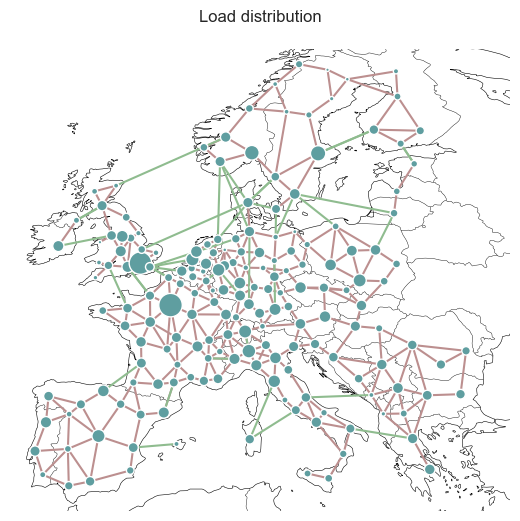

In [43]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

bus_locs = pd.Index(m_no.buses.location.unique())
load_distribution = m_no.loads_t.p[bus_locs].sum()/m_no.loads_t.p[bus_locs].sum().max()

m_no.plot(bus_sizes=1*load_distribution, ax=ax, projection=ccrs.EqualEarth())
ax.set_title("Load distribution", pad=20)
plt.show()
# same for m_h2

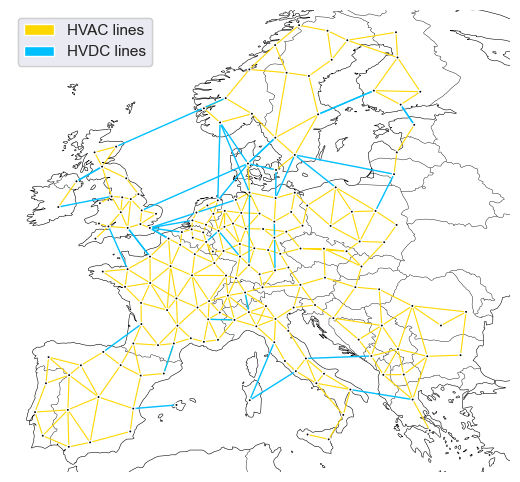

In [44]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

m_no.plot(ax=ax, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=0.8, link_widths=1)
pypsa.plot.add_legend_patches(ax=ax, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
plt.show()

In [45]:
# AC lines

In [46]:
# all AC network lines are froms same type
n_no.lines.type.unique()

array(['Al/St 240/40 4-bundle 380.0'], dtype=object)

In [47]:
# Optimised capacity for apparent power: capacities in megavolt amperes (MVA)
n_h2.lines.s_nom_opt.sum()
n_no.lines.s_nom_opt.sum()

1661313.524409717

In [48]:
# sum of all capacities of all AC lines is almost twice as high for the second network
n_h2.lines.s_nom_opt.sum() / n_no.lines.s_nom_opt.sum()

1.936867546113058

In [49]:
# DC cables

In [50]:
n_no.links[n_no.links.carrier == "DC"].p_nom_opt.sum()

16440.0

In [51]:
n_h2.links[n_h2.links.carrier == "DC"].p_nom_opt.sum()

184344.89875153708

In [52]:
n_h2.links[n_h2.links.carrier == "DC"].p_nom_opt.sum() / n_no.links[n_no.links.carrier == "DC"].p_nom_opt.sum()

11.213193354716367

In [53]:
# overall length of network

In [54]:
# AC lines (km)
n_no.lines.length.sum()

68396.95599455902

In [55]:
# DC lines (km)
n_no.links[n_no.links.carrier == "DC"].length.sum()

17893.88200995407

In [56]:
# AC lines (km)
n_h2.lines.length.sum()

68396.95599455902

In [57]:
n_h2.links[n_h2.links.carrier == "DC"].length.sum()

17893.88200995407

Findings:
- electricity network has the same lines in both scenarios, difference is in the capacity
- the lines (AC, DC) also have the same length
- The capacity of the AC lines are twice as high in the h2 case
- The capacity of the DC lines are 11 times higher than in the no case

### Hydrogen network

In [58]:
l_h2 = n_h2.copy()

locs = l_h2.buses[l_h2.buses.carrier == "AC"][["x","y"]]
mapping = pd.DataFrame(l_h2.buses[l_h2.buses.carrier == "H2"].location)
mapping["bus"] = mapping.index
mapping.set_index("location", inplace =True)
locs.index = locs.index.map(mapping.to_dict()['bus'])
l_h2.buses.x[l_h2.buses.carrier == "H2"] = locs.x
l_h2.buses.y[l_h2.buses.carrier == "H2"] = locs.y

l_h2.mremove("Bus",l_h2.buses[l_h2.buses.carrier != "H2"].index)

# write LineStrign into pipes (links)
h2_pipes = l_h2.links[l_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].index
other_links = l_h2.links[-l_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].index

for pipe in h2_pipes:
    loc1 = l_h2.buses.loc[l_h2.links.loc[pipe].bus0][["x", "y"]]
    loc2 = l_h2.buses.loc[l_h2.links.loc[pipe].bus1][["x", "y"]]
    l_h2.links.geometry.loc[pipe] = LineString([Point(loc1), Point(loc2)]).wkt

l_h2.mremove("Link", other_links)
l_h2.mremove("Line", l_h2.lines.index)

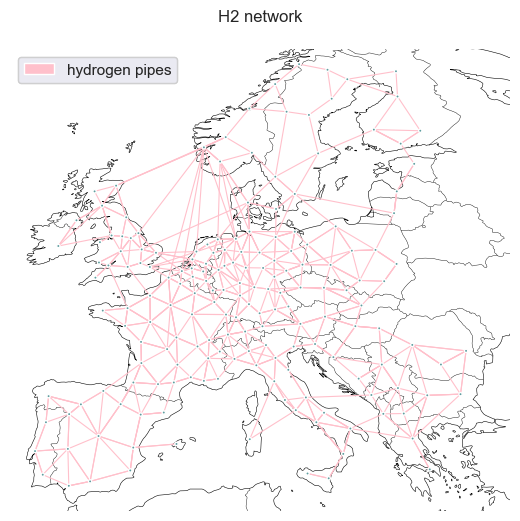

In [59]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

l_h2.plot(ax=ax, link_colors="pink", link_widths=0.8,  projection=ccrs.EqualEarth())
pypsa.plot.add_legend_patches(ax=ax, labels=["hydrogen pipes"], colors=["pink"], legend_kw={'loc': 'upper left'})
ax.set_title("H2 network", pad=20)
plt.show()

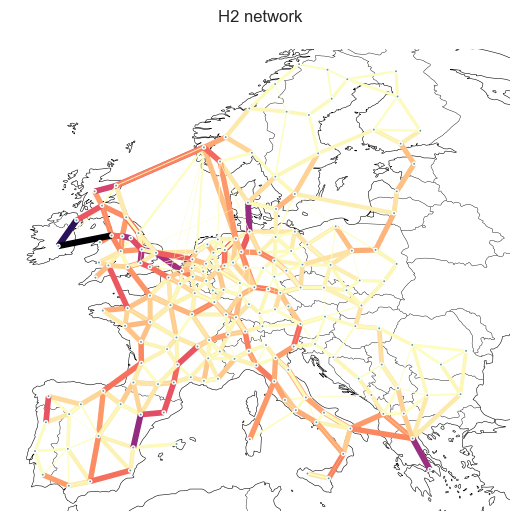

In [60]:
# adding colorbar to this

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

l_h2.links.p_max_pu
l_h2.plot(ax=ax, link_colors=l_h2.links.p_nom_opt, link_cmap=plt.get_cmap("magma_r"), link_widths=np.log10(l_h2.links.p_nom_opt),  projection=ccrs.EqualEarth())
ax.set_title("H2 network", pad=20)
plt.show()

In [61]:
# hydrogen pipeline network in km
n_h2.links[n_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].length.sum()

193545.8096976719

In [62]:
n_h2.links[n_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])]

bus0       bus1  \
Link                                                           
H2 pipeline retrofitted AL0 0 -> IT0 10  AL0 0 H2  IT0 10 H2   
H2 pipeline retrofitted AT0 0 -> AT0 2   AT0 0 H2   AT0 2 H2   
H2 pipeline retrofitted AT0 0 -> HU0 0   AT0 0 H2   HU0 0 H2   
H2 pipeline retrofitted AT0 0 -> SK0 0   AT0 0 H2   SK0 0 H2   
H2 pipeline retrofitted AT0 0 <-> AT0 2  AT0 0 H2   AT0 2 H2   
...                                           ...        ...   
H2 pipeline SE3 1 -> SE3 7               SE3 1 H2   SE3 7 H2   
H2 pipeline SE3 2 -> SE3 5               SE3 2 H2   SE3 5 H2   
H2 pipeline SE3 3 -> SE3 6               SE3 3 H2   SE3 6 H2   
H2 pipeline SE3 4 -> SE3 7               SE3 4 H2   SE3 7 H2   
H2 pipeline SE3 5 -> SE3 6               SE3 5 H2   SE3 6 H2   

                                                         carrier geometry  \
Link                                                                        
H2 pipeline retrofitted AL0 0 -> IT0 10  H2 pipeline retrofitted            
H2 pipeline retrofitted AT0 0 -> AT0 2   H2 pipeline retrofitted            
H2 pipeline retrofitted AT0 0 -> HU0 0   H2 pipeline retrofitted            
H2 pipeline retrofitted AT0 0 -> SK0 0   H2 pipeline retrofitted            
H2 pipeline retrofitted AT0 0 <-> AT0 2  H2 pipeline retrofitted            
...                                                          ...      ...   
H2 pipeline SE3 1 -> SE3 7                           H2 pipeline            
H2 pipeline SE3 2 -> SE3 5                           H2 pipeline            
H2 pipeline SE3 3 -> SE3 6                           H2 pipeline            
H2 pipeline SE3 4 -> SE3 7                           H2 pipeline            
H2 pipeline SE3 5 -> SE3 6                           H2 pipeline            

                                             length  p_nom  \
Link                                                         
H2 pipeline retrofitted AL0 0 -> IT0 10  254.011781    0.0   
H2 pipeline retrofitted AT0 0 -> AT0 2   228.454388    0.0   
H2 pipeline retrofitted AT0 0 -> HU0 0   274.453912    0.0   
H2 pipeline retrofitted AT0 0 -> SK0 0   372.071027    0.0   
H2 pipeline retrofitted AT0 0 <-> AT0 2  228.454388    0.0   
...                                             ...    ...   
H2 pipeline SE3 1 -> SE3 7               272.988128    0.0   
H2 pipeline SE3 2 -> SE3 5               141.983342    0.0   
H2 pipeline SE3 3 -> SE3 6               222.522966    0.0   
H2 pipeline SE3 4 -> SE3 7               161.813506    0.0   
H2 pipeline SE3 5 -> SE3 6               751.431228    0.0   

                                                                                      tags  \
Link                                                                                         
H2 pipeline retrofitted AL0 0 -> IT0 10                 INET_PL_669_EE_0_Seg_0_Seg_0_Seg_0   
H2 pipeline retrofitted AT0 0 -> AT0 2                                PLS_6292_Seg_0_Seg_0   
H2 pipeline retrofitted AT0 0 -> HU0 0   ST_929_Seg_0_Seg_0_Seg_1 PLS_4606_Seg_0_Seg_0_...   
H2 pipeline retrofitted AT0 0 -> SK0 0                            EntsoG_Map__ST_423_Seg_0   
H2 pipeline retrofitted AT0 0 <-> AT0 2                          PLL_709_Seg_0_Seg_0_Seg_3   
...                                                                                    ...   
H2 pipeline SE3 1 -> SE3 7                                                                   
H2 pipeline SE3 2 -> SE3 5                                                                   
H2 pipeline SE3 3 -> SE3 6                                                                   
H2 pipeline SE3 4 -> SE3 7                                                                   
H2 pipeline SE3 5 -> SE3 6                                                                   

                                         under_construction  underground  \
Link                                                                       
H2 pipeline retrofitted AL0 

## Installed Capacity, Generation, Consumption

In [63]:
cap_no = pd.DataFrame(index=n_no.buses.location.unique())
cap_h2 = pd.DataFrame(index=n_h2.buses.location.unique())

for n, df in zip([n_no, n_h2], [cap_no,cap_h2]):

    for c in n.generators.carrier.unique():
        # capacity in GW
        df[c] = capacity(n, c) / 1000

    for c in n.links.carrier.unique():
        # capacity in GW
        df[c] = capacity_links(n, c) / 1000

    for c in n.storage_units.carrier.unique():
        # capacity in GW
        df[c] = capacity_storage_units(n, c) / 1000

# condense groups
cap_no = get_condense_sum(cap_no, c1_groups, c1_groups_name)
cap_h2 = get_condense_sum(cap_h2, c1_groups, c1_groups_name)
# rename unhandy column names
cap_no.rename(columns=carrier_renaming, inplace=True)
cap_h2.rename(columns=carrier_renaming, inplace=True)

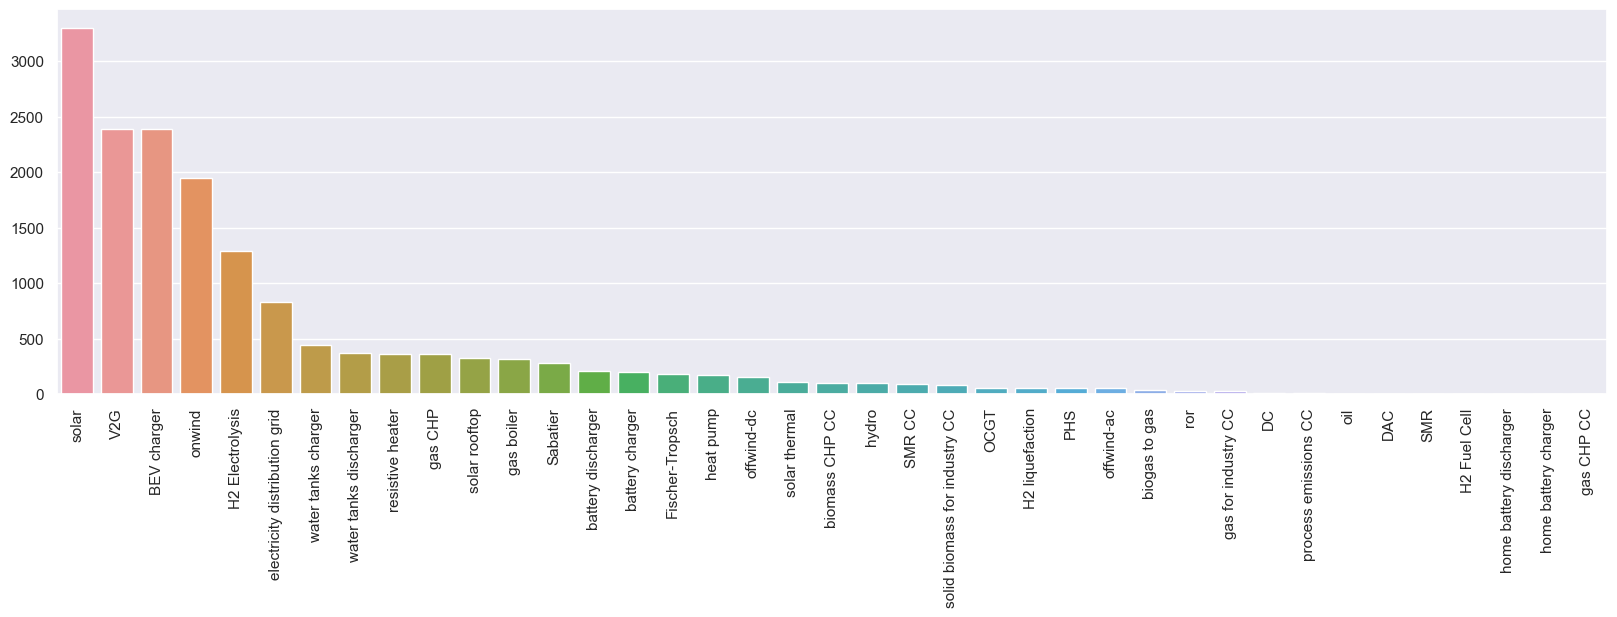

In [64]:
cap_no_sum = pd.DataFrame(cap_no.sum().sort_values(ascending=False)).transpose()
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_no_sum.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

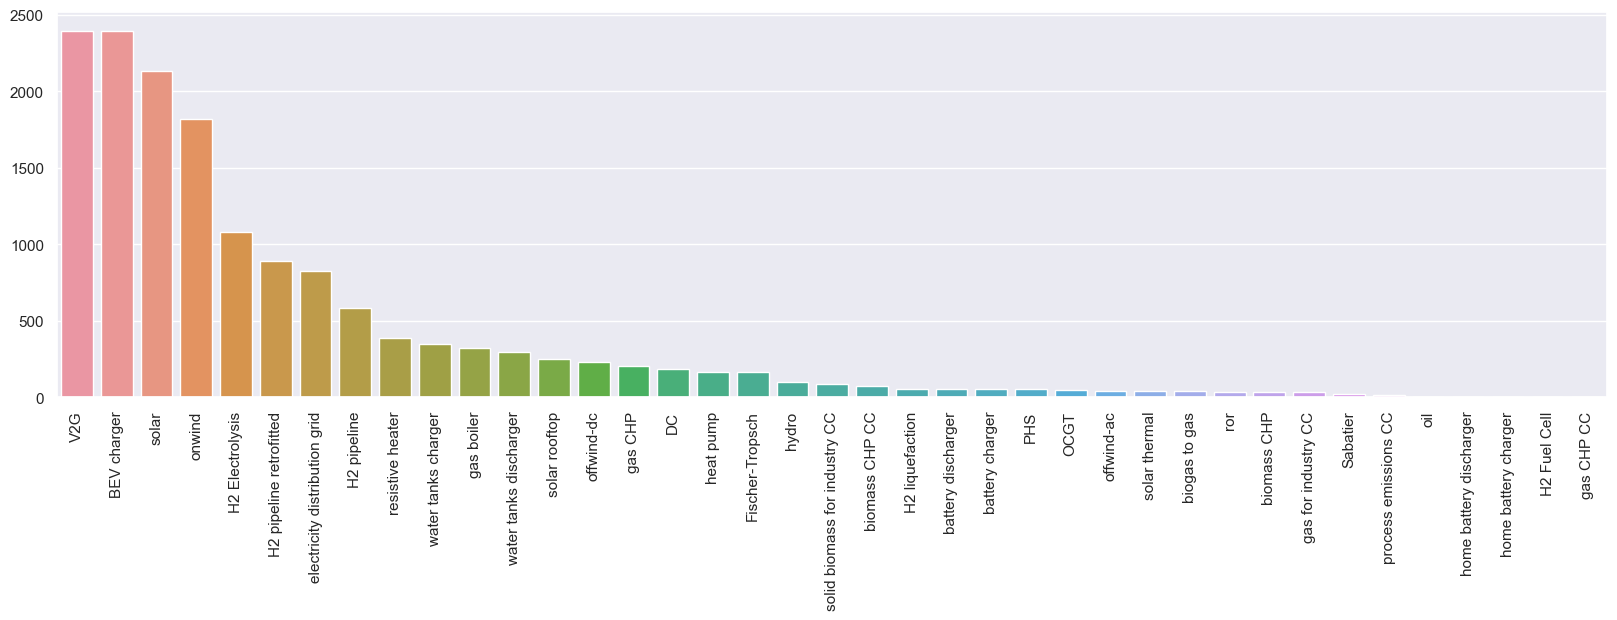

In [65]:
cap_h2_sum = pd.DataFrame(cap_h2.sum().sort_values(ascending=False)).transpose()
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_h2_sum.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

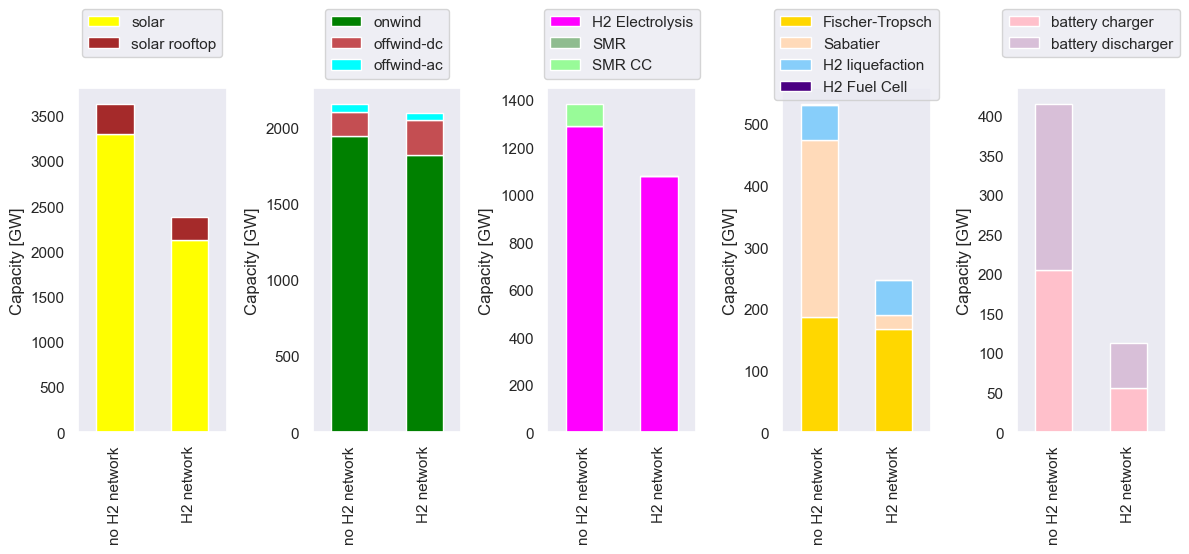

In [66]:
# thesis_plot

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["solar" , "solar rooftop"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["onwind", "offwind-dc", "offwind-ac"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["H2 Electrolysis", "SMR", "SMR CC"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["Fischer-Tropsch", "Sabatier", "H2 liquefaction", "H2 Fuel Cell"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["battery charger", "battery discharger"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(loc='upper center', bbox_to_anchor=bbox)

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/system_overview/capa_scenarios.png")

In [67]:
carriers = ["Fischer-Tropsch", "Sabatier", "H2 liquefaction", "H2 Fuel Cell"]
get_df(cap_no_sum, cap_h2_sum, carriers)

Fischer-Tropsch    Sabatier  H2 liquefaction  H2 Fuel Cell
no H2 network       186.510890  287.047057        57.402323      1.113744
H2 network          167.978457   21.849055        57.402323      0.005168

In [68]:
# magnitude is in GW
carriers = ["battery charger", "battery discharger"]
round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose() / round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose().sum()
# round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).sum(axis=1)

no H2 network  H2 network
battery charger          0.493976    0.495575
battery discharger       0.506024    0.504425

In [69]:
# magnitude is in GW
carriers = ["H2 Fuel Cell"]
round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose()
# round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).sum(axis=1)

no H2 network  H2 network
H2 Fuel Cell            1.0         0.0


Notes:
- 'H2 pipeline', 'H2 pipeline retrofitted' are the only difference in the carriers (n_no does not have them)
- H2 Fuel Cell Capacity is not really existent: capacity without H2 network is 1 GW and with H2 network it is 0


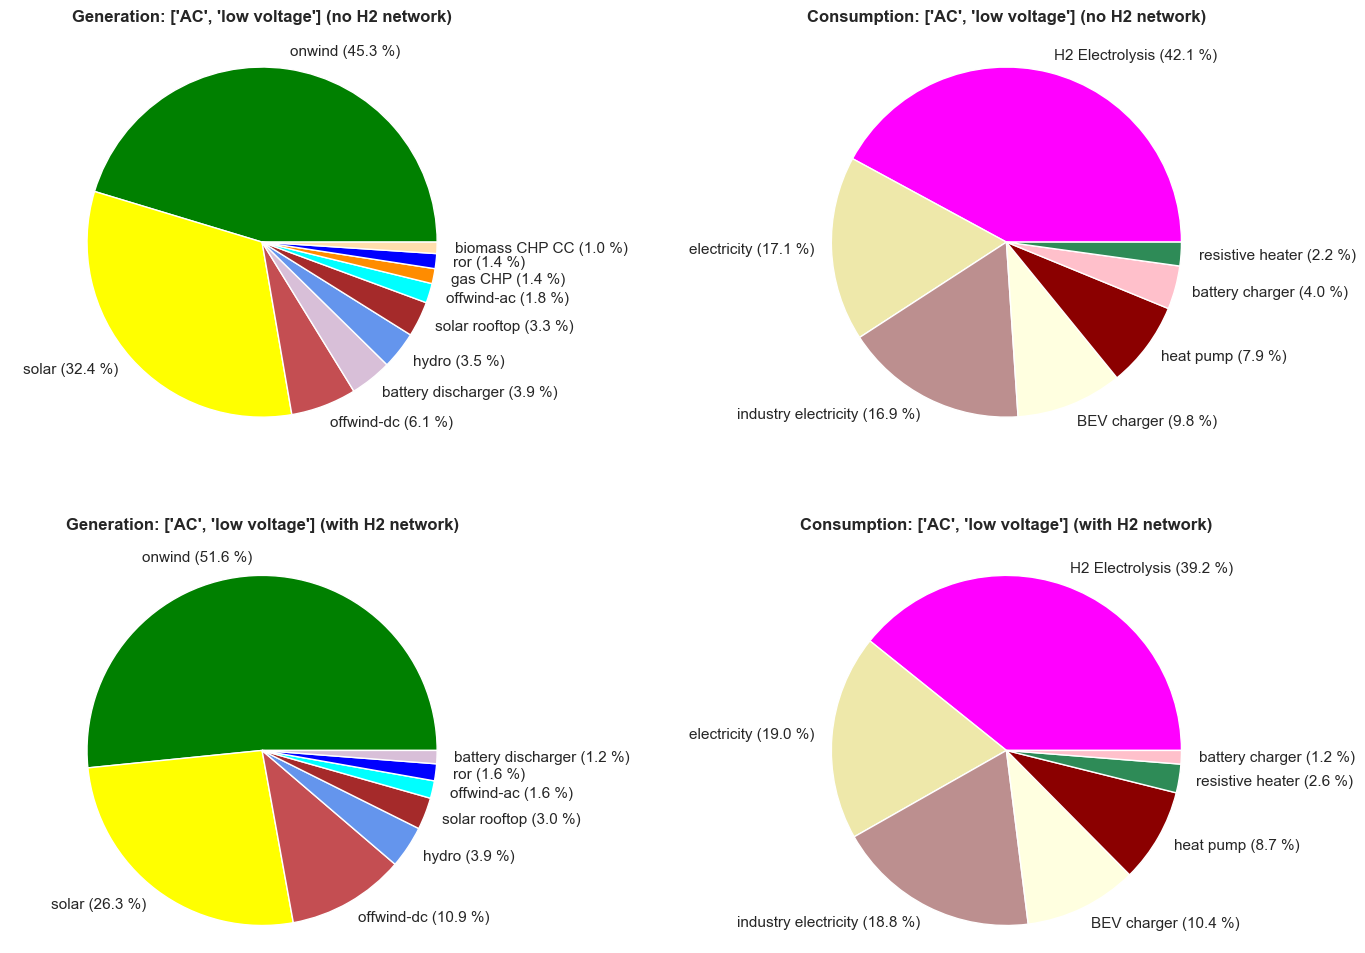

In [70]:
# thesis_plot:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["AC", "low voltage"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000
    # condense condense_groups
    nb = get_condense_sum(nb, c1_groups, c1_groups_name)
    # rename unhandy column names
    nb.rename(columns=carrier_renaming, inplace=True)

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (no H2 network)"
        title_con=f"Consumption: {carrier} (no H2 network)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (with H2 network)"
        title_con=f"Consumption: {carrier} (with H2 network)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/system_overview/gen_con_ac_lowvoltage.png")

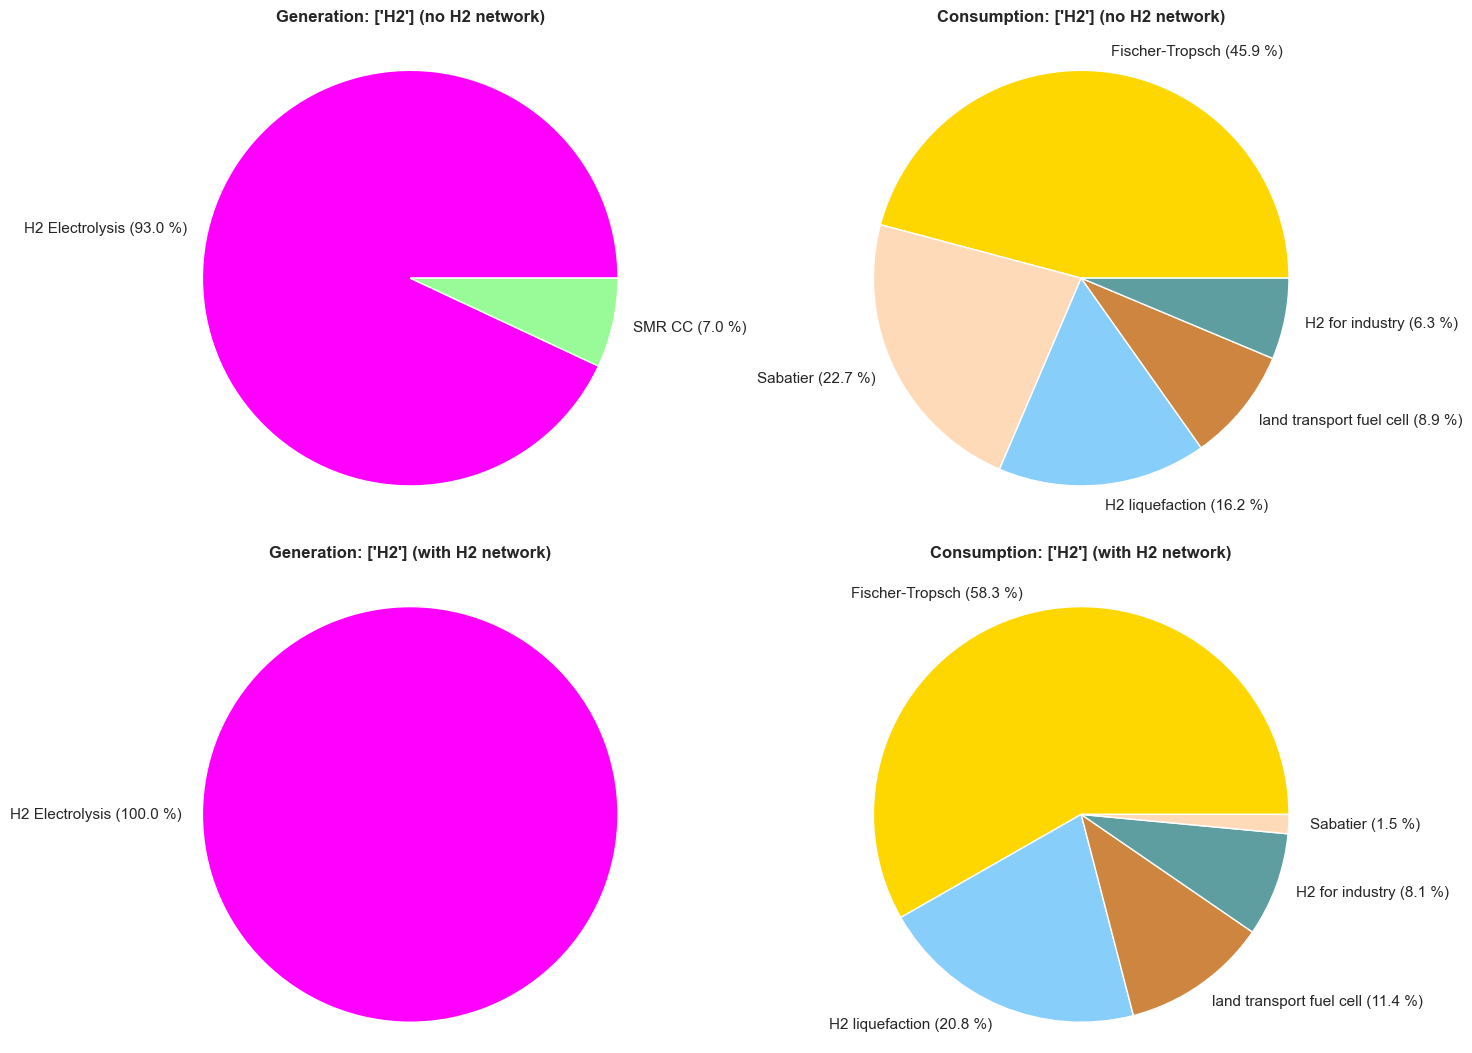

In [71]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["H2"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (no H2 network)"
        title_con=f"Consumption: {carrier} (no H2 network)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (with H2 network)"
        title_con=f"Consumption: {carrier} (with H2 network)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/5.1_hydrogen_overview/gen_con_h2.png")

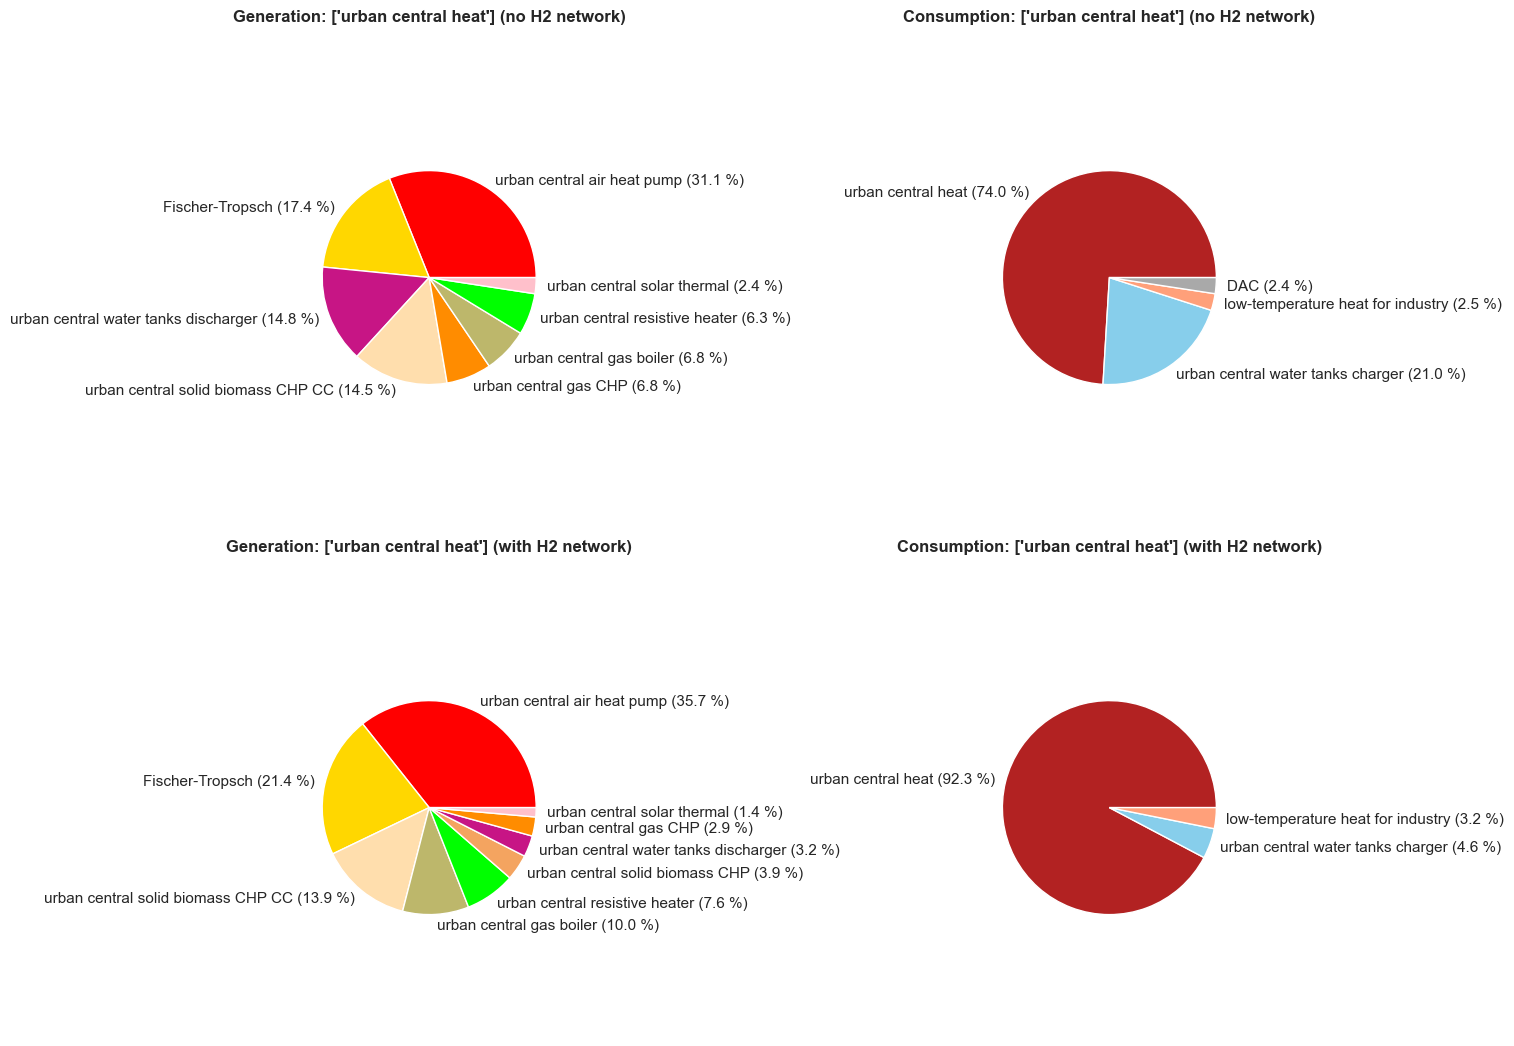

In [72]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["urban central heat"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (no H2 network)"
        title_con=f"Consumption: {carrier} (no H2 network)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (with H2 network)"
        title_con=f"Consumption: {carrier} (with H2 network)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
plt.show()

# Fischer Tropsch nebenprdukt Heat

#### Correlation of Capacity

In [73]:
cap_no.corr()["H2 Electrolysis"].sort_values(ascending=False)

H2 Electrolysis                  1.000000
onwind                           0.674504
water tanks discharger           0.435677
water tanks charger              0.391454
solar                            0.317964
home battery discharger          0.220959
home battery charger             0.220959
H2 liquefaction                  0.209788
resistive heater                 0.199608
OCGT                             0.195322
electricity distribution grid    0.142353
offwind-dc                       0.140394
BEV charger                      0.140047
V2G                              0.140047
offwind-ac                       0.058708
H2 Fuel Cell                     0.050625
heat pump                        0.042430
gas boiler                       0.016798
DC                               0.001610
battery discharger              -0.029855
battery charger                 -0.029855
gas CHP                         -0.050279
PHS                             -0.062228
SMR                             -0

In [74]:
cap_h2.corr()["H2 pipeline retrofitted"].sort_values(ascending=False)

H2 pipeline retrofitted          1.000000
gas CHP                          0.165576
offwind-dc                       0.137909
heat pump                        0.090337
gas CHP CC                       0.082084
electricity distribution grid    0.081157
gas boiler                       0.067722
resistive heater                 0.050328
onwind                           0.044667
H2 Fuel Cell                     0.044022
BEV charger                      0.041010
V2G                              0.041010
H2 Electrolysis                  0.040551
battery discharger               0.030149
battery charger                  0.030149
H2 pipeline                      0.014772
SMR                             -0.002298
H2 liquefaction                 -0.003621
offwind-ac                      -0.008828
water tanks discharger          -0.036245
OCGT                            -0.036723
water tanks charger             -0.042427
biomass CHP                     -0.062418
solar thermal                   -0

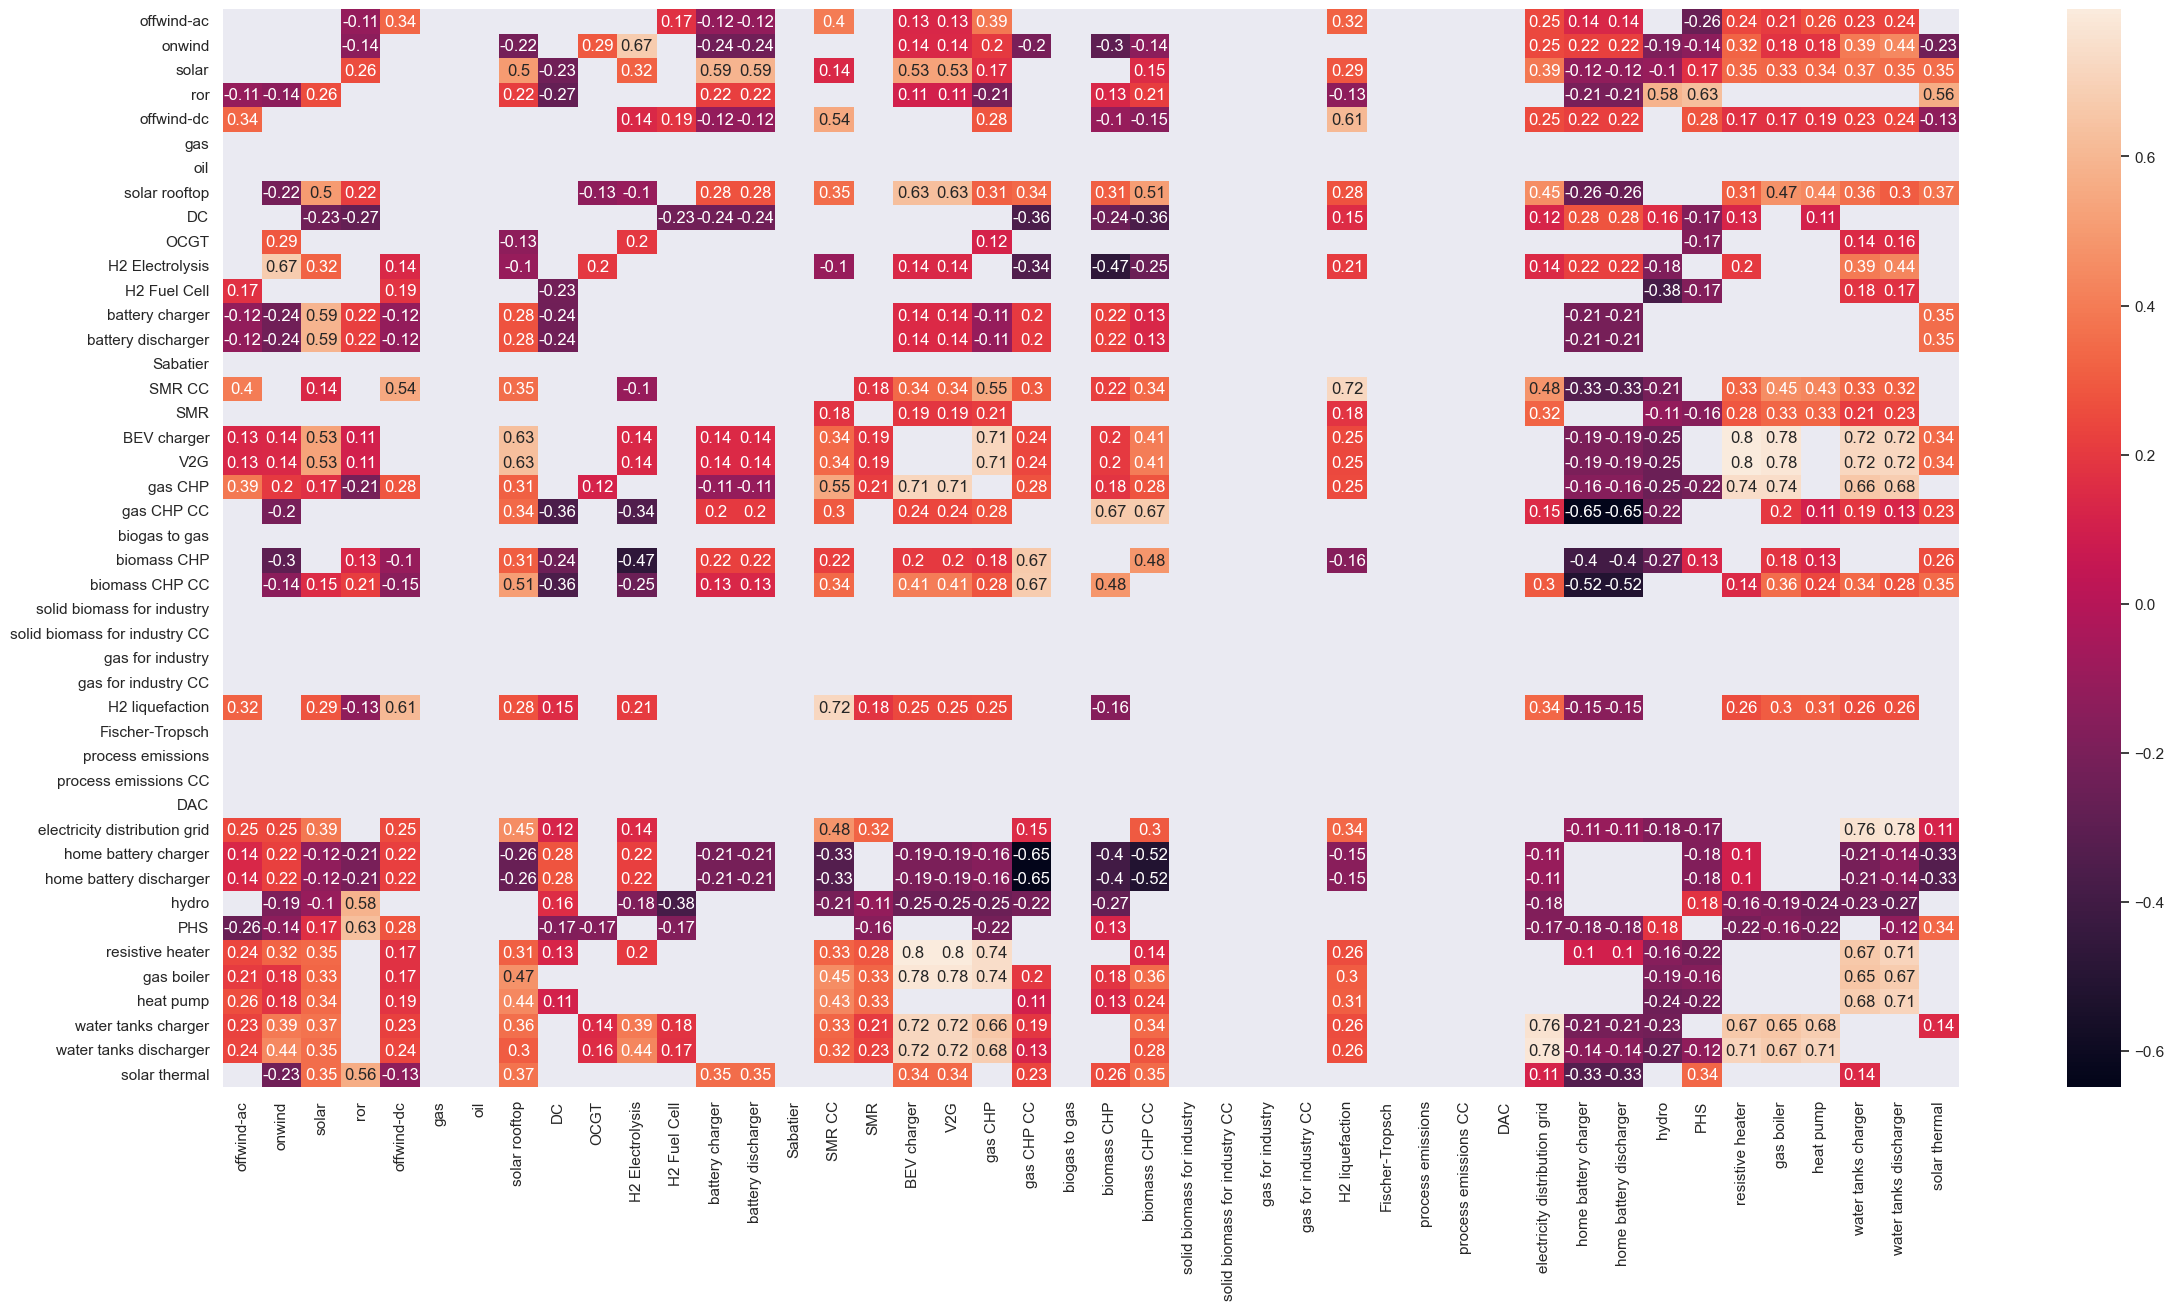

In [75]:
# check correlation of capacities to check at which locations similar technologies are present
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_no.corr()[(abs(cap_no.corr()) > 0.1) & (abs(cap_no.corr()) < 0.8)], annot=True)
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/system_overview/no_h2_capa_corr.png")

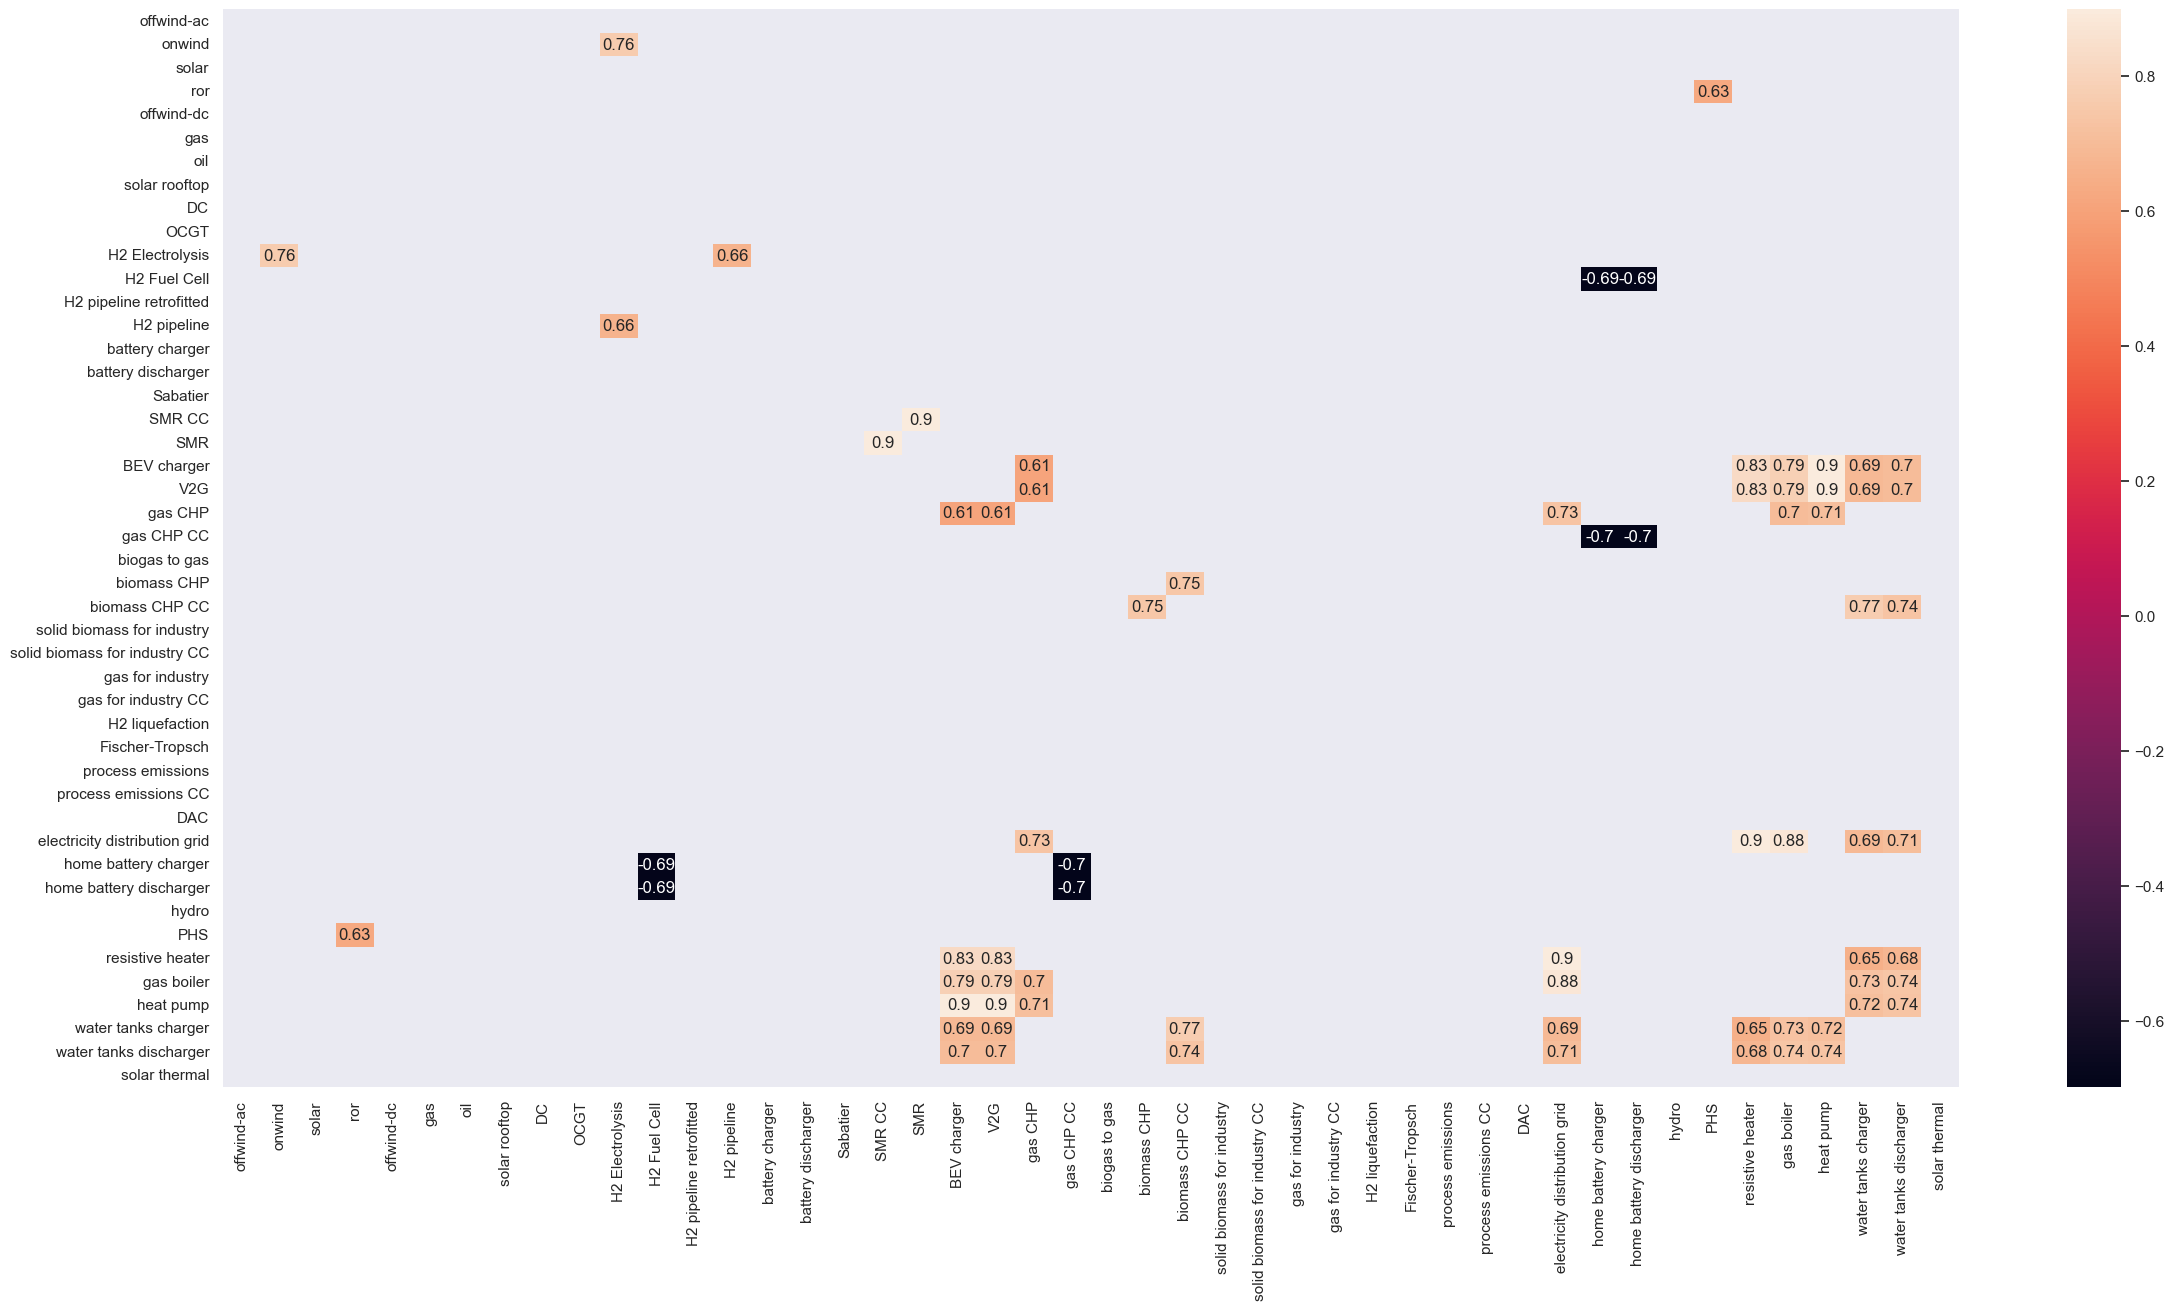

In [76]:
# check correlation of capacities to check at which location similar technologies are present
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_h2.corr()[(abs(cap_h2.corr()) > 0.6) & (abs(cap_h2.corr()) < 0.9)], annot=True)
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/system_overview/h2_capa_corr.png")

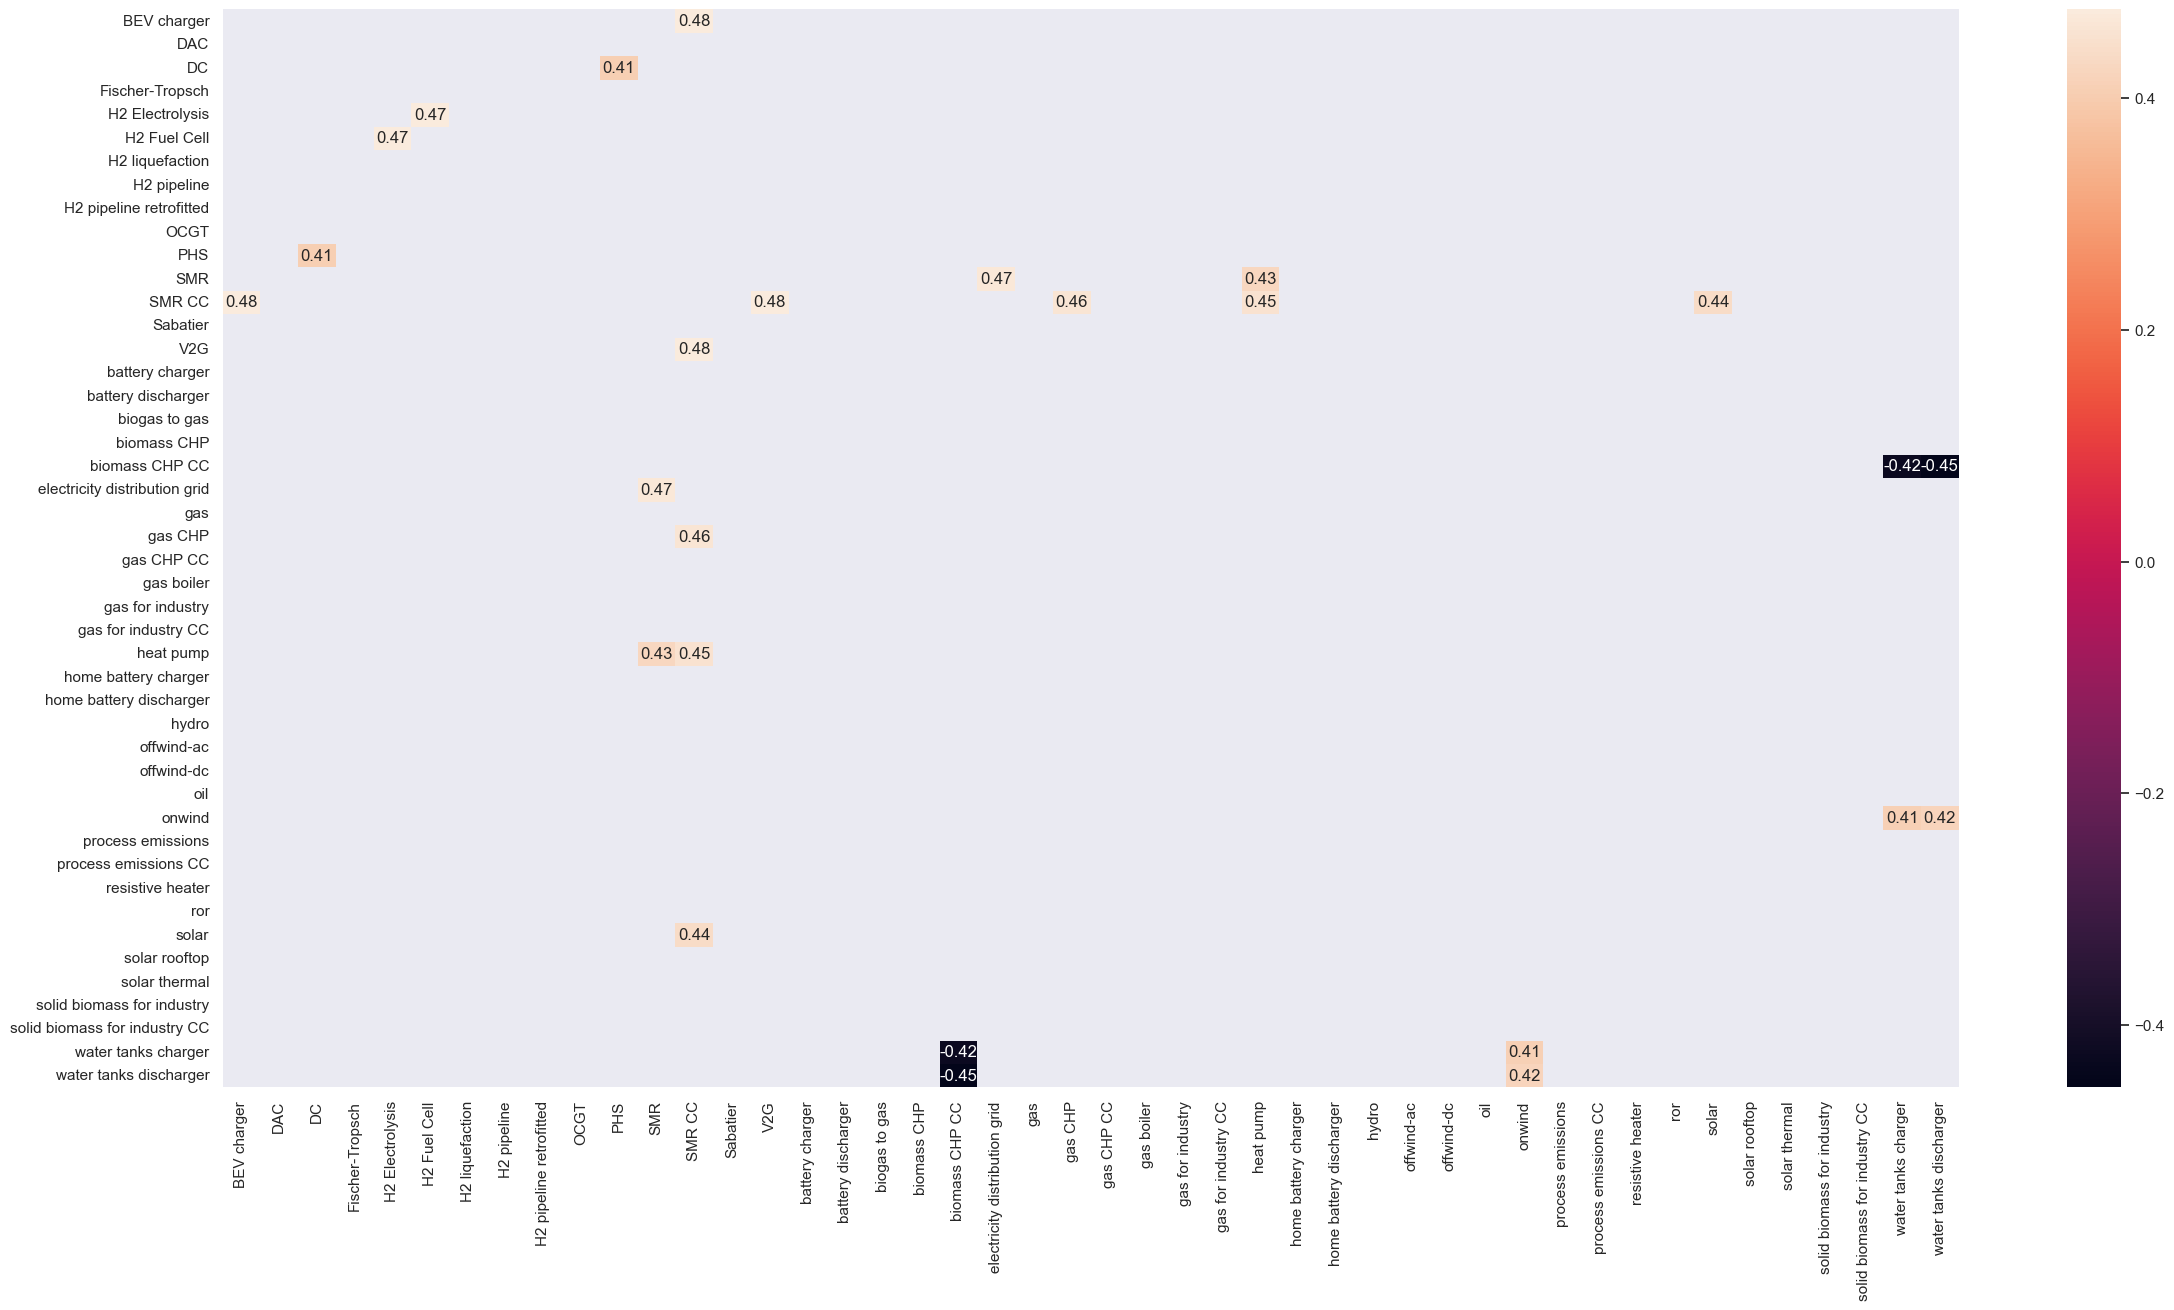

In [77]:
fig = plt.figure(figsize=(28, 14))
diff_cap = cap_no.corr() - cap_h2.corr()
sns.heatmap(diff_cap[(abs(diff_cap) > 0.4) & (abs(diff_cap) < 0.5)], annot=True)
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/system_overview/capa_corr_diff_no_minus_h2.png")

Findings: correlation of capacities amogn the scenarios

Interesting and making sense:
- H2 Electrolysis and onwind: (no: 0.67; h2: 0.76) -> onshore wind dominantly used for hydrogen production
- H2 Electrolysis and solar: (no: 0.32; h2: 0.37) -> solar wind partly used for hydrogen production
- H2 Electrolysis and H2 pipeline: 0.66 -> hydrogen production at locations with pipelines
- onwind and h2 pipeline. 0.57 -> onwind used for hydrogen production close to h2 pipelines; pipelines are build where a lot of onwind is located
- offwind-dc and H2 liquefaction: 0.61 ; 0.35 -> offshore wind used to produced liquefied hydrogen (more present in STST scenario as there is less possibility to transport away the offshore wind power generation)

- solar and battery charger: (no: 0.59; h2: 0.54) -> solar used for utility scale battery charging
- BEV and solar rooftop: (STST: 0.63 ; EXP: 0.56) -> solar used to charge vehicles
- BEV and solar: (STST: 0.53 ; EXP: 0.22) -> solar used to charge vehicles

- gas CHP and heat pump / gas boilder / resistive heater : (no: 0.83, 0.72, 0.72 ; h2: 0.71 , 0.7, 0.58) -> all heat sources are at the same location
- gas CHP and biomass CHP / biomas CHP CC: 0.67 / 0.67 ; 0.44 / 0.3 -> all heat sources are at the same location
- gas CHP and water tanks charger: 0.66 ; 0.53 -> heat used for charging thermal storage
- water tanks charger and heat pump / gas boiler / resisitive heater: 0.68 / 0.65 / 0.67 ; 0.73/ 0.72 / 0.65 -> heat used for charging thermal storage

Not making sense or not interesting?:
- biomas CHP and water tanks charger / discharger; (no: 0.007/ 0.048 ; h2: 0.59, 0.55) -> Why no correlation in STST case?
- biomass CHP and home battery charger: -0.52 ; -0.23
- gas CHP CC and home battery charger: -0.65 ; -0.7
- H2 Electrolysis and water tanks charger / water tanks discharger: ( no: 0.39 / 0.44 ; -0.12 / < abs(0.1)) -> rather random?

Not interesting and making sense:
- solar and solar rooftop (0.5 ; 0.47)
- solar thermal and solar: 0.56 ; 0.41

Not interesting and not making sense:
- H2 Fuel cell and home battery charger / home battery discharger: (no: -0.032; h2: -0.69) not very relevant as there is almost no capacity of fuel cell
- SMR CC and H2 liquefaction: (no: 0.72; h2: -0.16) strong correlation with SMR CC and H2 liquefaction in STST scenario; small correlation in EXP scenario random due to little capacity of SMR CC
- H2 Fuel Cell and biomass CHP / biomass CHP CC: (no: 0.032 / <0.01 ; ) H2 Fuel Cell has no relevance

In [78]:
n_no.links[n_no.links.carrier == "urban central water tanks charger"]

bus0  \
Link                                                                
AL0 0 urban central water tanks charger  AL0 0 urban central heat   
AT0 0 urban central water tanks charger  AT0 0 urban central heat   
AT0 1 urban central water tanks charger  AT0 1 urban central heat   
AT0 2 urban central water tanks charger  AT0 2 urban central heat   
BA0 0 urban central water tanks charger  BA0 0 urban central heat   
...                                                           ...   
SE3 5 urban central water tanks charger  SE3 5 urban central heat   
SE3 6 urban central water tanks charger  SE3 6 urban central heat   
SE3 7 urban central water tanks charger  SE3 7 urban central heat   
SI0 0 urban central water tanks charger  SI0 0 urban central heat   
SK0 0 urban central water tanks charger  SK0 0 urban central heat   

                                                                    bus1  \
Link                                                                       
AL0 0 urban central water tanks charger  AL0 0 urban central water tanks   
AT0 0 urban central water tanks charger  AT0 0 urban central water tanks   
AT0 1 urban central water tanks charger  AT0 1 urban central water tanks   
AT0 2 urban central water tanks charger  AT0 2 urban central water tanks   
BA0 0 urban central water tanks charger  BA0 0 urban central water tanks   
...                                                                  ...   
SE3 5 urban central water tanks charger  SE3 5 urban central water tanks   
SE3 6 urban central water tanks charger  SE3 6 urban central water tanks   
SE3 7 urban central water tanks charger  SE3 7 urban central water tanks   
SI0 0 urban central water tanks charger  SI0 0 urban central water tanks   
SK0 0 urban central water tanks charger  SK0 0 urban central water tanks   

                                                                   carrier  \
Link                                                                         
AL0 0 urban central water tanks charger  urban central water tanks charger   
AT0 0 urban central water tanks charger  urban central water tanks charger   
AT0 1 urban central water tanks charger  urban central water tanks charger   
AT0 2 urban central water tanks charger  urban central water tanks charger   
BA0 0 urban central water tanks charger  urban central water tanks charger   
...                                                                    ...   
SE3 5 urban central water tanks charger  urban central water tanks charger   
SE3 6 urban central water tanks charger  urban central water tanks charger   
SE3 7 urban central water tanks charger  urban central water tanks charger   
SI0 0 urban central water tanks charger  urban central water tanks charger   
SK0 0 urban central water tanks charger  urban central water tanks charger   

                                        geometry  length  p_nom tags  \
Link                                                                   
AL0 0 urban central water tanks charger              0.0    0.0        
AT0 0 urban central water tanks charger              0.0    0.0        
AT0 1 urban central water tanks charger              0.0    0.0        
AT0 2 urban central water tanks charger              0.0    0.0        
BA0 0 urban central water tanks charger              0.0    0.0        
...                                          ...     ...    ...  ...   
SE3 5 urban central water tanks charger              0.0    0.0        
SE3 6 urban central water tanks charger              0.0    0.0        
SE3 7 urban central water tanks charger              0.0    0.0        
SI0 0 urban central water tanks charger              0.0    0.0        
SK0 0 urban central water tanks charger              0.0    0.0        

                                         under_construction  underground  \
Link                                                                       
AL0 0 urban central water tanks charger                 NaN          N

#### Capacity Coverage (%)
- calc capacities in percentage
- calc the min(capA, capB) for every location to see how many percentage points are present at a location from both technologies. If it is 100, the distributio of capacity is the same, if it is 0, there is no capacity present of technology A at the same location where capacity of technology B is present.
- measure the similarity of the distribution
how to calc that?

In [79]:
# Note: gas, oil, sabatier, biogas to gas, ... only have capacity at EU bus

cap_no_perc = pd.DataFrame(cap_no.fillna(0) / cap_no.fillna(0).sum())
cap_h2_perc = pd.DataFrame(cap_h2.fillna(0) / cap_h2.fillna(0).sum())

# exclude all carriers that only have capacity at EU bus
cap_no_perc = cap_no_perc[cap_no_perc.columns[cap_no_perc.loc["EU"]!=1]]
cap_h2_perc = cap_h2_perc[cap_h2_perc.columns[cap_h2_perc.loc["EU"]!=1]]

# drop EU row
cap_no_perc.drop("EU", inplace=True)
cap_h2_perc.drop("EU", inplace=True)

cap_no_cc = pd.DataFrame(index=cap_no_perc.columns, columns=cap_no_perc.columns)
cap_h2_cc = pd.DataFrame(index=cap_h2_perc.columns, columns=cap_h2_perc.columns)

for c1 in cap_no_cc.columns:
    for c2 in cap_no_cc.index:
        cap_no_cc.loc[c1, c2] = cap_no_perc[[c1, c2]].min(axis=1).sum()

for c1 in cap_h2_cc.columns:
    for c2 in cap_h2_cc.index:
        cap_h2_cc.loc[c1, c2] = cap_h2_perc[[c1, c2]].min(axis=1).sum()

# convert to float
cap_no_cc = cap_no_cc.astype(float)
cap_h2_cc = cap_h2_cc.astype(float)

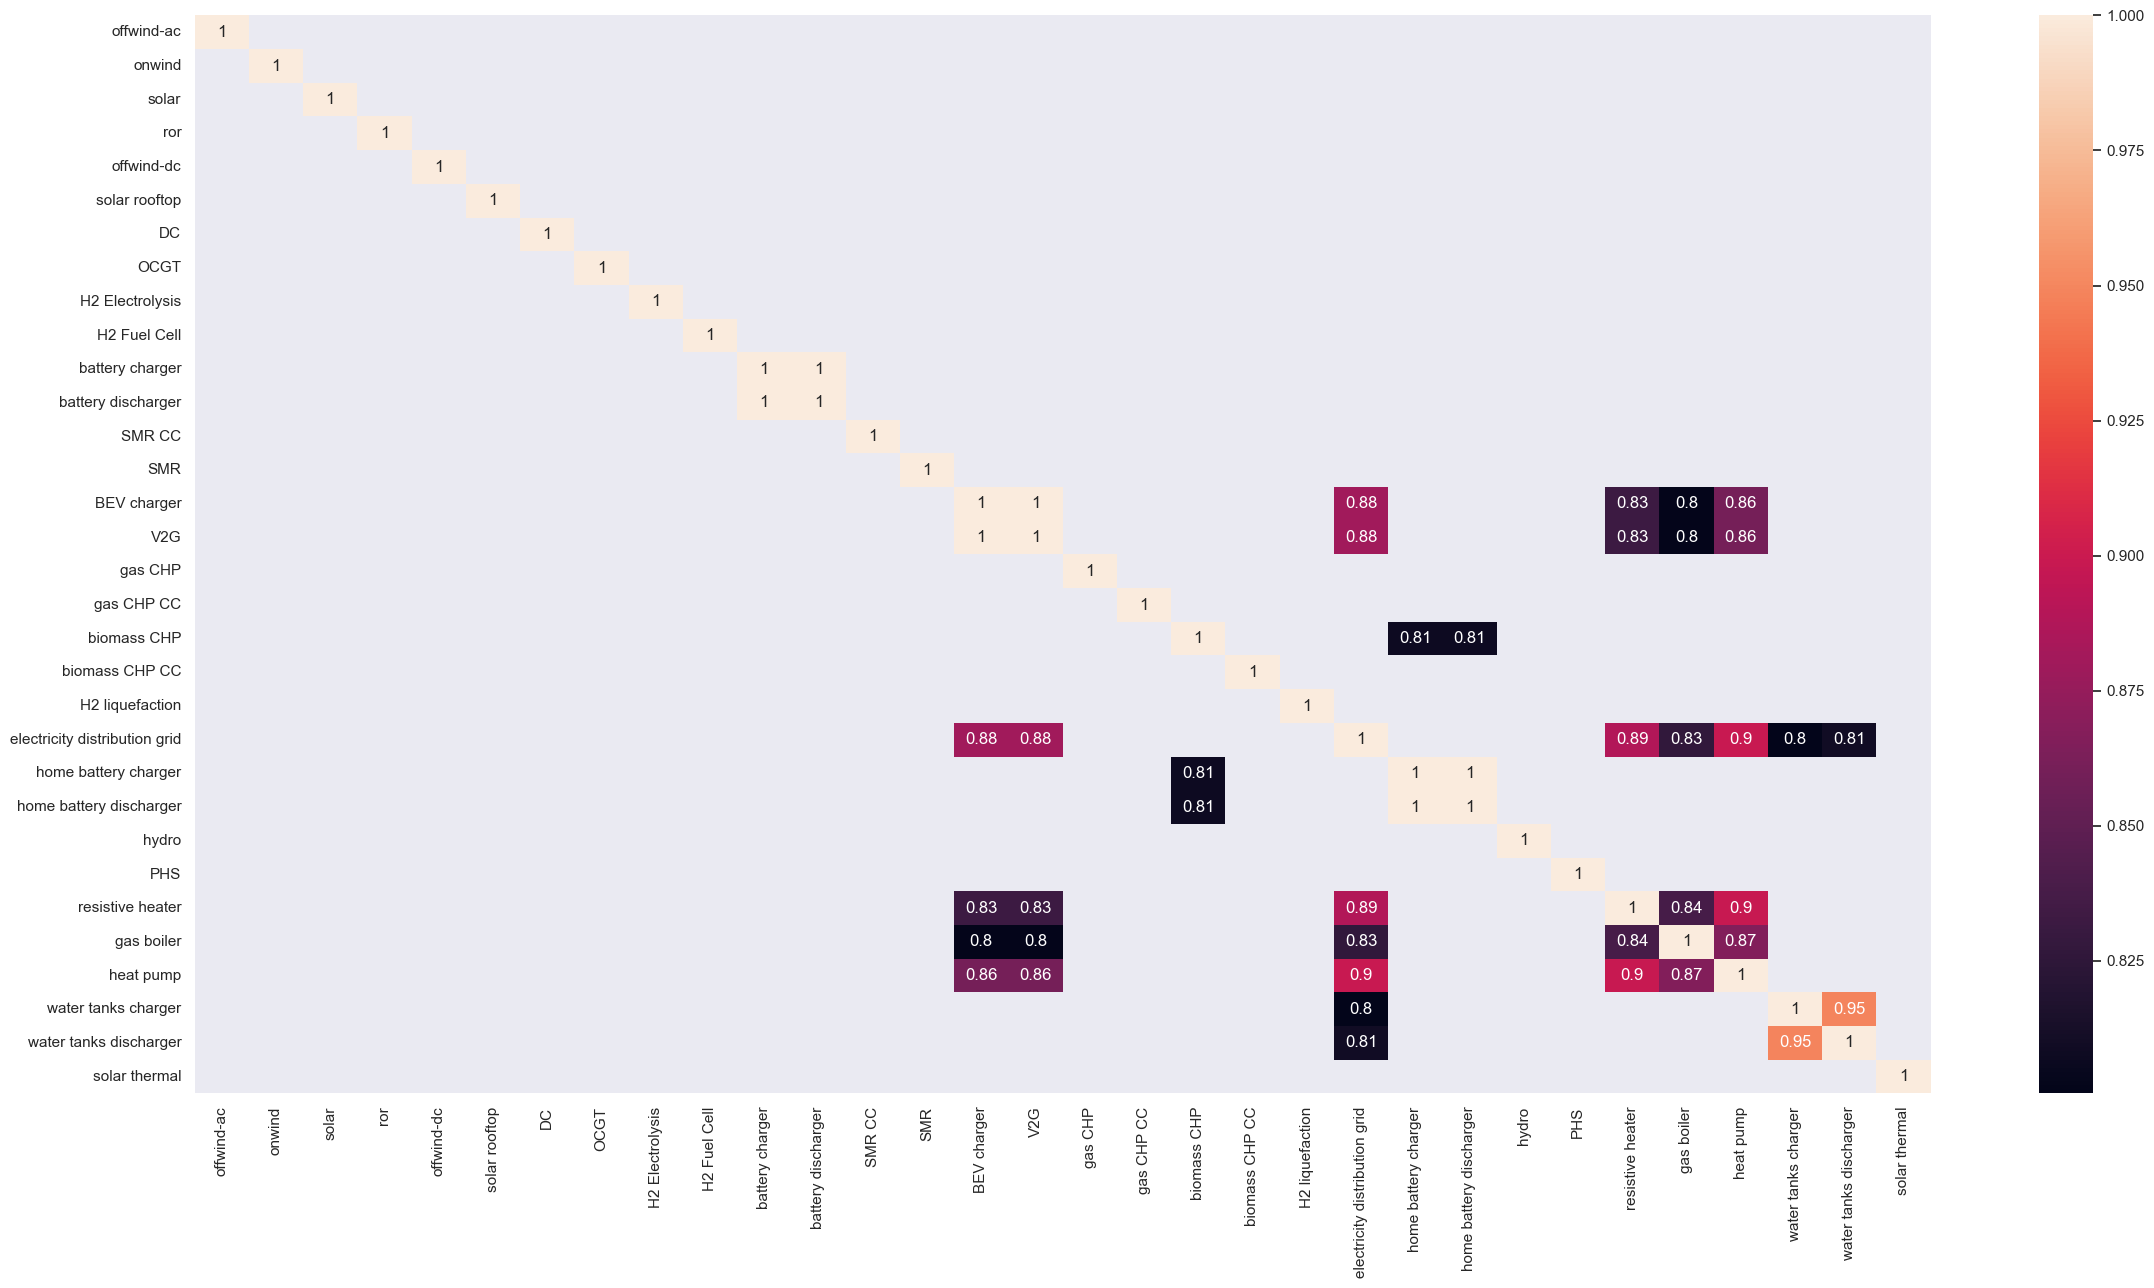

In [80]:
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_no_cc[cap_no_cc >0.8], annot=True)
plt.show()

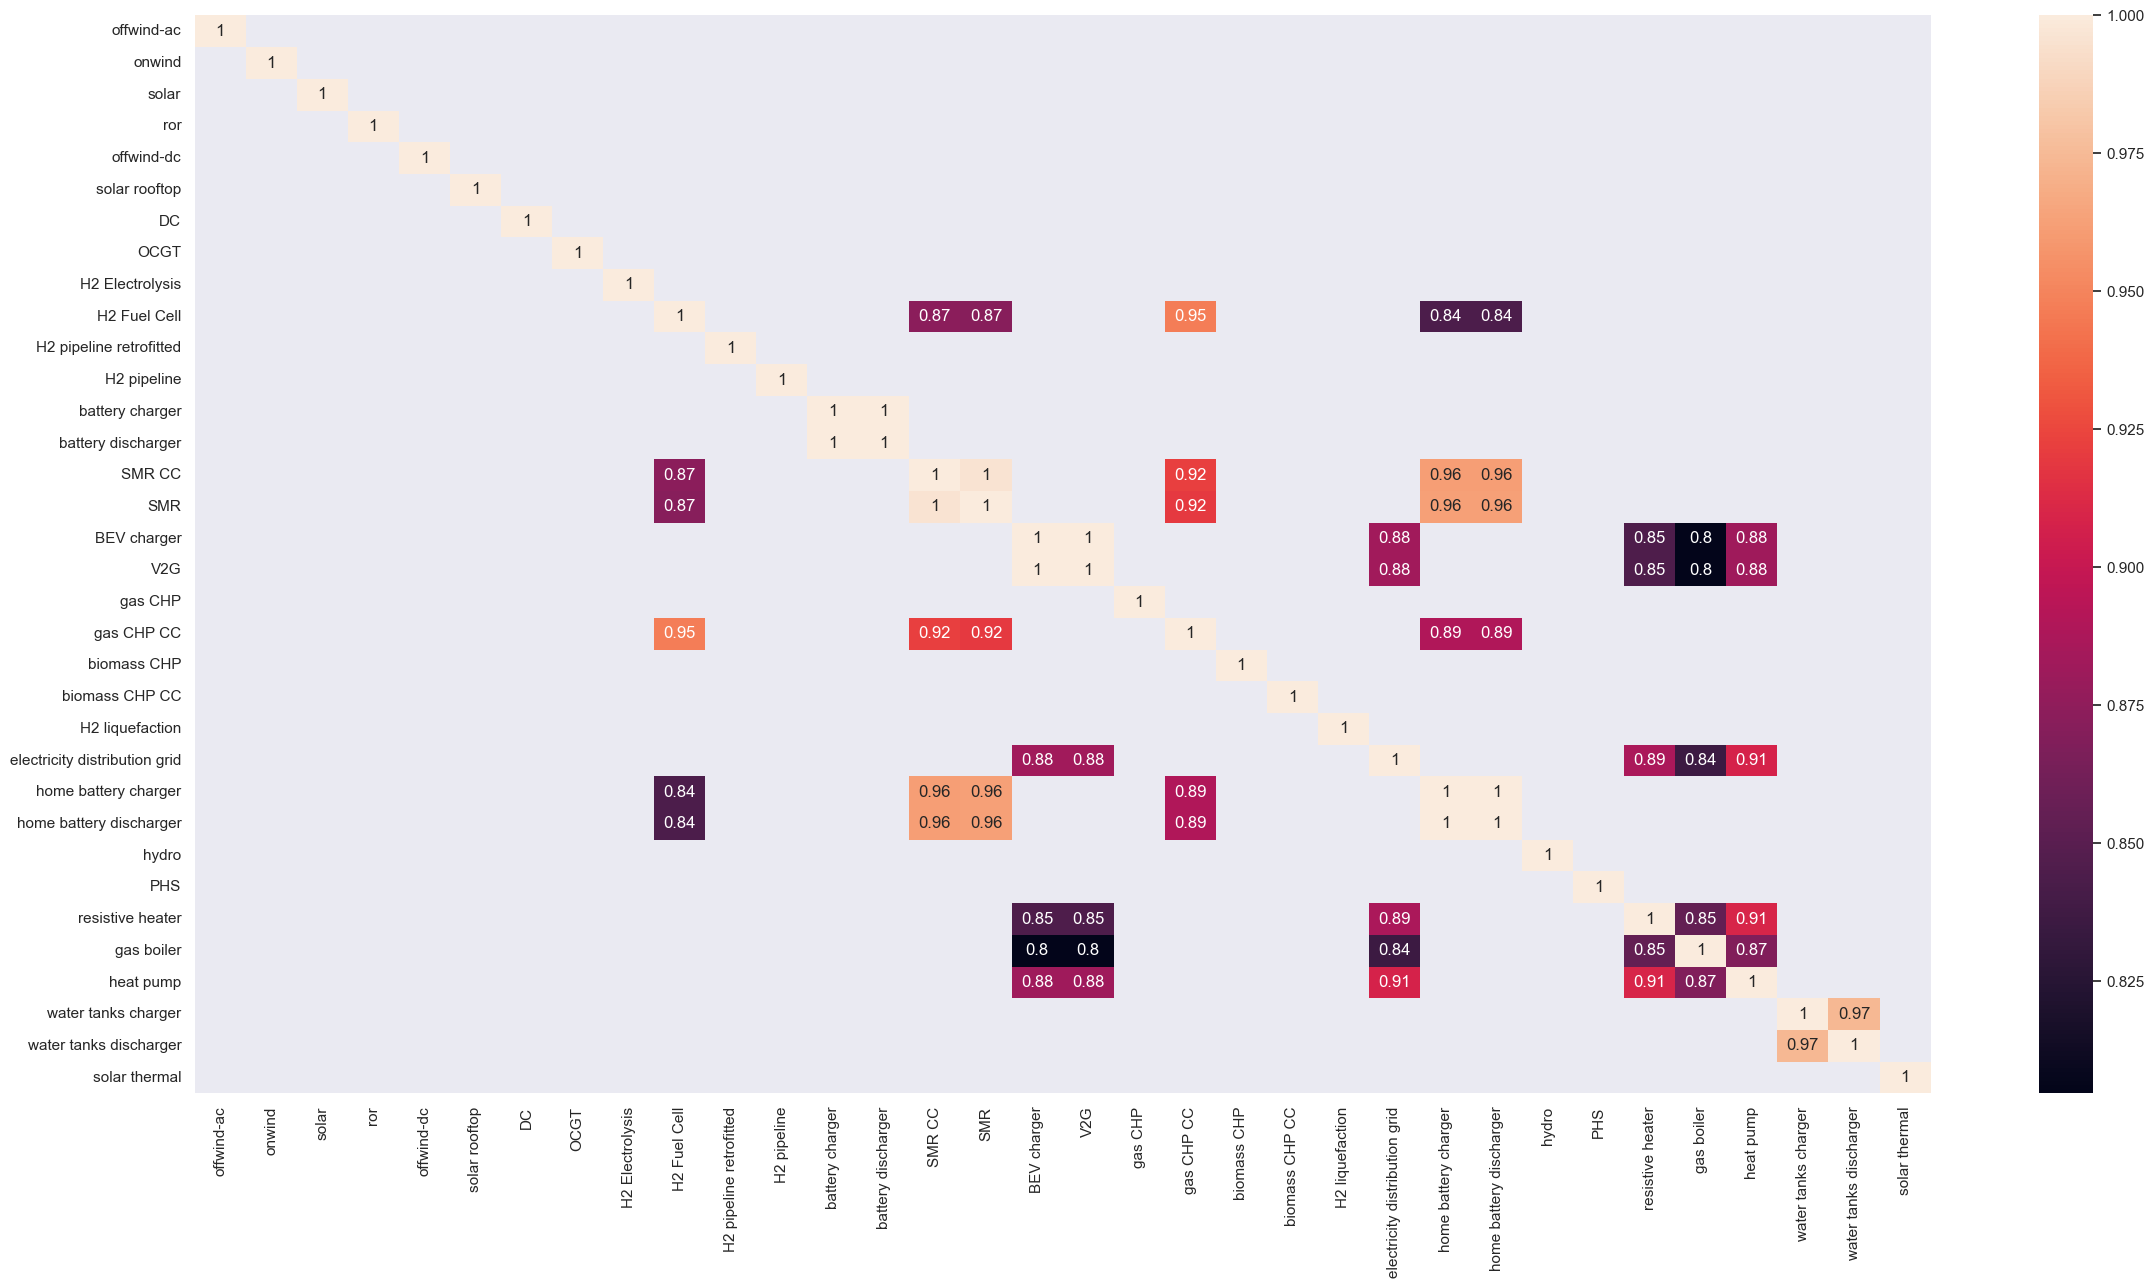

In [81]:
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_h2_cc[cap_h2_cc > 0.8], annot=True)
plt.show()

In [82]:
round(cap_no_cc - cap_h2_cc.loc[cap_no_cc.index, cap_no_cc.columns], 2)

offwind-ac  onwind  solar   ror  offwind-dc  \
offwind-ac                          -0.00    0.02   0.07 -0.00        0.02   
onwind                               0.02   -0.00   0.16  0.04       -0.03   
solar                                0.07    0.16   0.00  0.00        0.07   
ror                                 -0.00    0.04   0.00  0.00       -0.02   
offwind-dc                           0.02   -0.03   0.07 -0.02       -0.00   
solar rooftop                        0.05    0.16   0.10 -0.02        0.03   
DC                                   0.03   -0.11  -0.04 -0.06        0.01   
OCGT                                -0.00    0.18   0.04 -0.06        0.10   
H2 Electrolysis                      0.03    0.00   0.13  0.08       -0.05   
H2 Fuel Cell                        -0.06   -0.34  -0.41 -0.32       -0.14   
battery charger                      0.02    0.10   0.28  0.24        0.03   
battery discharger                   0.02    0.10   0.28  0.24        0.03   
SMR CC                               0.16   -0.12  -0.00 -0.04        0.06   
SMR                                  0.10   -0.23  -0.20 -0.20       -0.05   
BEV charger                          0.02    0.14   0.23  0.00        0.00   
V2G                                  0.02    0.14   0.23  0.00        0.00   
gas CHP                             -0.00    0.12   0.20  0.01       -0.03   
gas CHP CC                          -0.02   -0.00   0.13  0.02       -0.07   
biomass CHP                          0.06    0.34   0.41  0.08        0.11   
biomass CHP CC                      -0.01    0.09   0.15  0.01       -0.01   
H2 liquefaction                      0.01    0.04   0.08  0.00        0.02   
electricity distribution grid        0.03    0.15   0.21 -0.01        0.01   
home battery charger                 0.03    0.14   0.20 -0.00        0.00   
home battery discharger              0.03    0.14   0.20 -0.00        0.00   
hydro                                0.00    0.03   0.00  0.00       -0.00   
PHS                                  0.00    0.04   0.04  0.00       -0.03   
resistive heater                     0.04    0.14   0.20 -0.00        0.01   
gas boiler                           0.02    0.11   0.21  0.00        0.01   
heat pump                            0.03    0.12   0.22 -0.00       -0.00   
water tanks charger                  0.05    0.23   0.21 -0.06        0.05   
water tanks discharger               0.06    0.24   0.21 -0.07        0.06   
solar thermal                        0.00   -0.07  -0.07  0.19       -0.03   

                               solar rooftop    DC  OCGT  H2 Electrolysis  \
offwind-ac                              0.05  0.03 -0.00             0.03   
onwind                                  0.16 -0.11  0.18             0.00   
solar                                   0.10 -0.04  0.04             0.13   
ror                                    -0.02 -0.06 -0.06             0.08   
offwind-dc                              0.03  0.01  0.10            -0.05   
solar rooftop                           0.00 -0.07 -0.02             0.16   
DC                                     -0.07  0.00  0.08            -0.10   
OCGT                                   -0.02  0.08 -0.00             0.18   
H2 Electrolysis                         0.16 -0.10  0.18            -0.00   
H2 Fuel Cell                           -0.48 -0.13 -0.10            -0.24   
battery charger                         0.33 -0.07  0.06             0.10   
battery discharger                      0.33 -0.07  0.06             0.10   
SMR CC                                  0.03 -0.06  0.01            -0.13   
SMR                                    -0.24 -0.10  0.00            -0.18   
BEV charger                             0.13 -0.06  0.02             0.22   
V2G                                     0.13 -0.06  0.02             0.22   
gas CHP                                 0.18 -0.08  0.05             0.17   
gas CHP CC                              0.12 -0.11  0.03             0

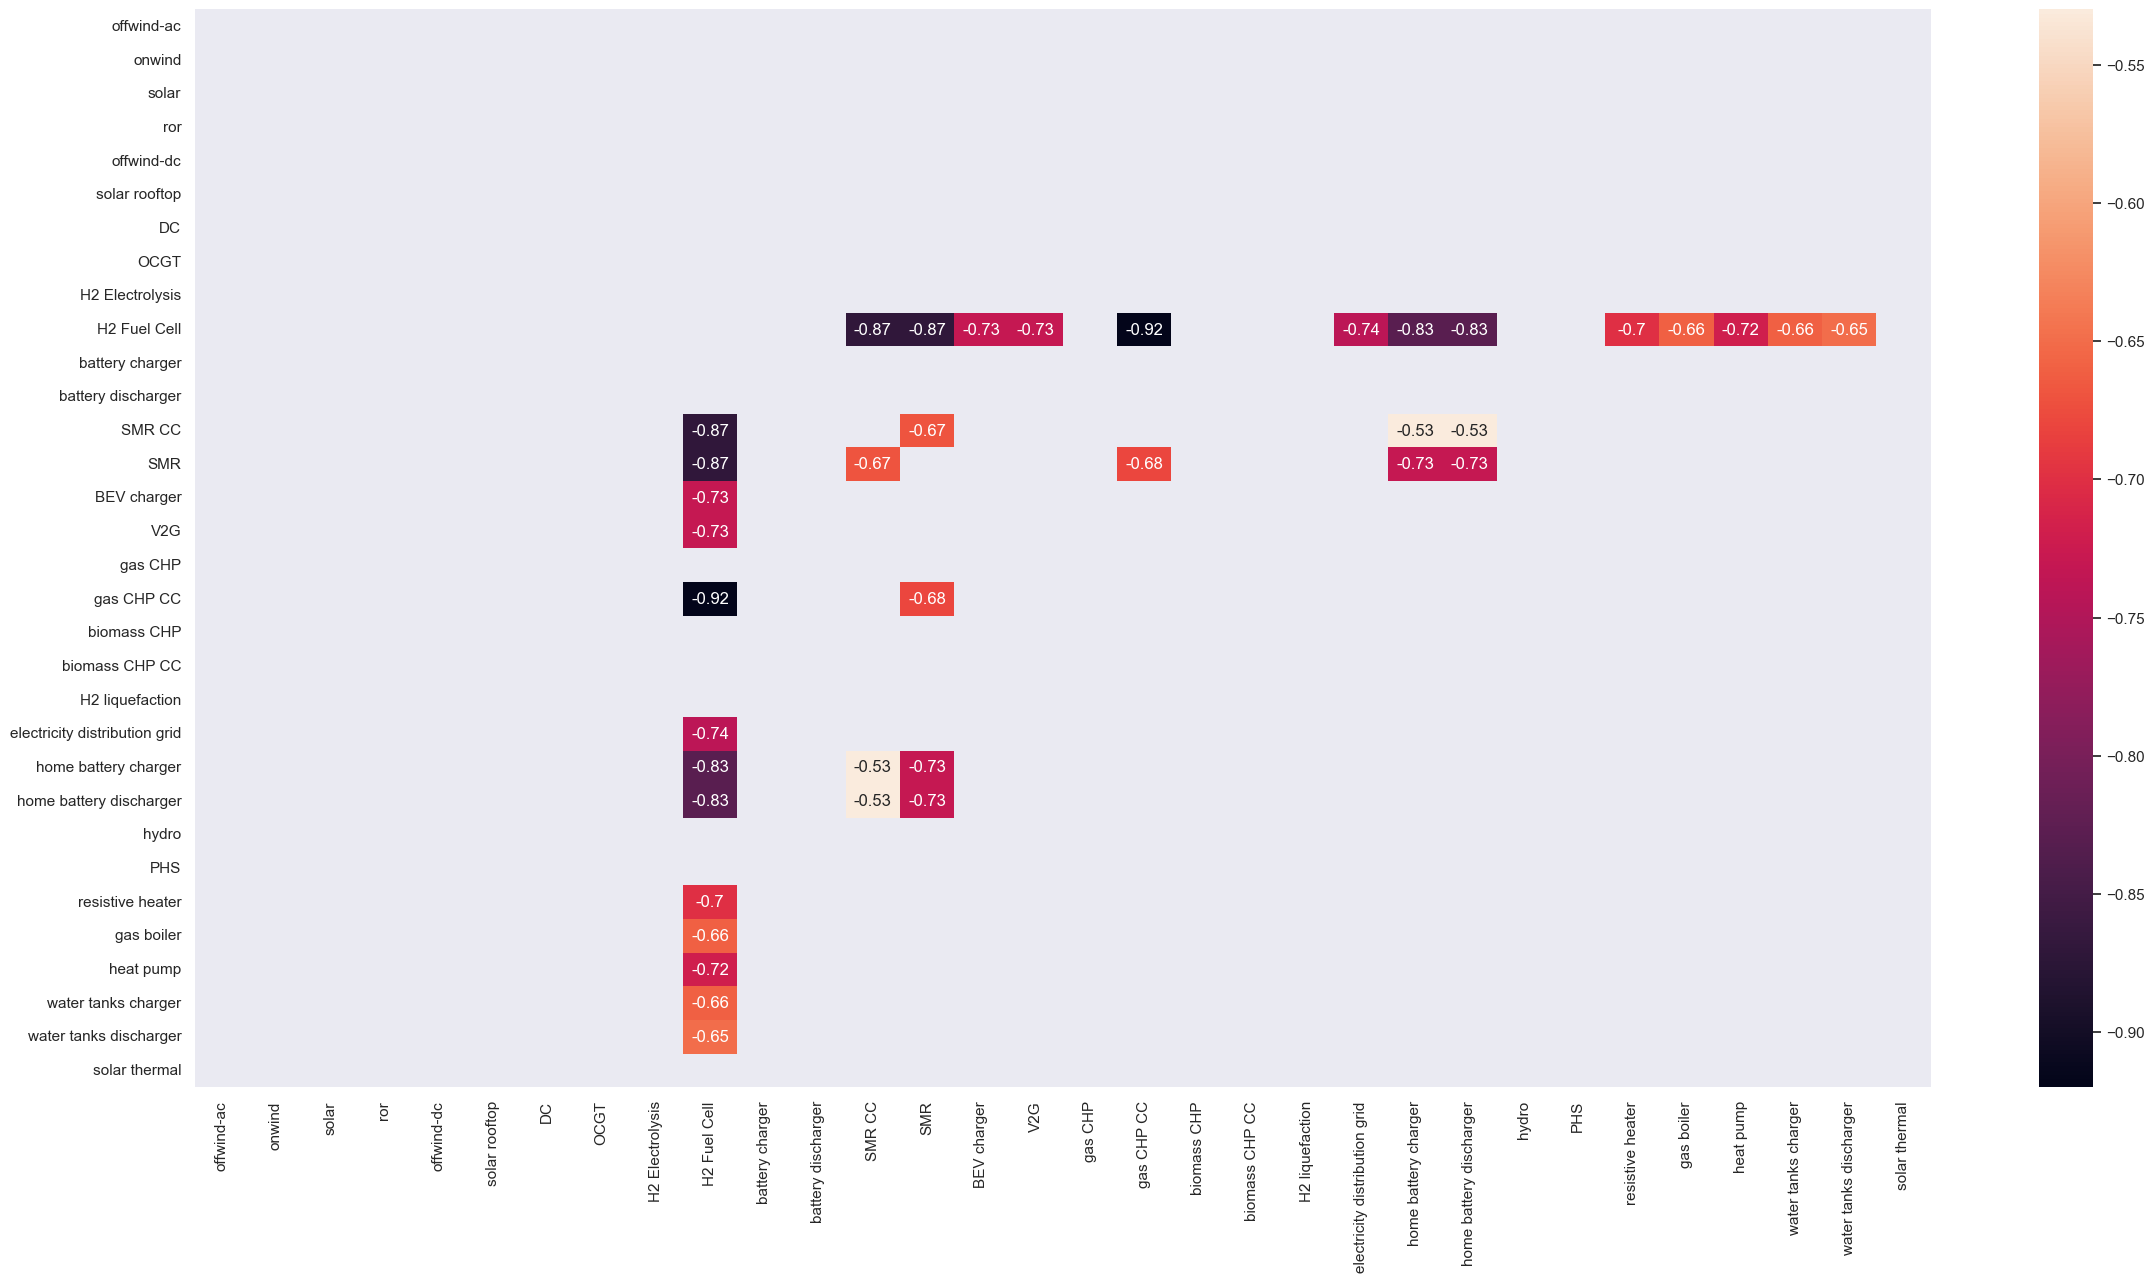

In [83]:
fig = plt.figure(figsize=(28, 14))
diff_cc = round(cap_no_cc - cap_h2_cc.loc[cap_no_cc.index, cap_no_cc.columns], 2)
sns.heatmap(diff_cc[abs(diff_cc) > 0.5], annot=True)
plt.show()

## Energy Flow

### Balance map

In [84]:
# plot map with overall balance of hydrogen and electricity per region

![](../../../../Pictures/Screenshots/Screenshot_20230215_101123.png)

In [123]:
# carrier of buses are the same for the networks
n_h2.buses.carrier.unique().tolist() == n_no.buses.carrier.unique().tolist()

True

In [86]:
n_h2.buses.carrier.unique().tolist()

['AC',
 'co2',
 'co2 stored',
 'gas',
 'H2',
 'battery',
 'Li ion',
 'residential rural heat',
 'residential rural water tanks',
 'services rural heat',
 'services rural water tanks',
 'residential urban decentral heat',
 'residential urban decentral water tanks',
 'services urban decentral heat',
 'services urban decentral water tanks',
 'urban central heat',
 'urban central water tanks',
 'biogas',
 'solid biomass',
 'solid biomass for industry',
 'gas for industry',
 'H2 liquid',
 'oil',
 'process emissions',
 'low voltage',
 'home battery']

In [129]:
test = nodal_balance(n_no, carrier=["AC", "low voltage"], time="2013", energy=True) # aggregate=["component", "snapshot", "carrier"]

In [138]:
test2 = nodal_balance(n_no, carrier=["AC", "low voltage"],aggregate=["component", "snapshot", "carrier"], time="2013", energy=True)
test2

bus
AL0 0    333.340198
AT0 0     24.109425
AT0 1     29.777586
AT0 2     59.505479
BA0 0    262.371388
            ...    
SE3 5   -174.010336
SE3 6   -188.713297
SE3 7   -427.935814
SI0 0     49.241415
SK0 0     80.663653
Length: 181, dtype: float64

In [137]:
test.groupby(["bus"]).sum()

bus
AL0 0    333.340198
AT0 0     24.109425
AT0 1     29.777586
AT0 2     59.505479
BA0 0    262.371388
            ...    
SE3 5   -174.010336
SE3 6   -188.713297
SE3 7   -427.935814
SI0 0     49.241415
SK0 0     80.663653
Length: 181, dtype: float64

In [121]:
# oil, gas, co2 is only at EU level
carrier_sets = [["AC", "low voltage"], ["H2"], ["urban central heat"], ["AC", "low voltage", "H2"]]

for carrier_set in carrier_sets:
    # nodal balance in MWh
    df_no_ons[f"{carrier_set}_nb"] = nodal_balance(n_no, carrier=carrier_set, time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)
    df_h2_ons[f"{carrier_set}_nb"] = nodal_balance(n_h2, carrier=carrier_set, time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)

df_no_ons.iloc[: , -10:].head()

gas for industry_lmp  H2 liquid_lmp    oil_lmp  process emissions_lmp  \
name                                                                           
AL0 0            113.135704     137.617875  50.009981            -408.520212   
AT0 0            113.135704     151.448316  50.009981            -408.520212   
AT0 1            113.135704     154.026970  50.009981            -408.520212   
AT0 2            113.135704     148.663198  50.009981            -408.520212   
BA0 0            113.135704     147.689672  50.009981            -408.520212   

       low voltage_lmp  home battery_lmp  ['AC', 'low voltage']_nb  ['H2']_nb  \
name                                                                            
AL0 0       100.338046        100.380697                 -0.922246  -1.287429   
AT0 0       115.006246        115.044440                 -2.052619   1.103885   
AT0 1       121.910720        121.947576                 -1.793313   0.459835   
AT0 2       112.352878        112.386673                 -1.112482   1.399385   
BA0 0       112.040690        112.006725                 -2.511227   1.410499   

       ['urban central heat']_nb  ['AC', 'low voltage', 'H2']_nb  
name                                                              
AL0 0                  -1.923377                       -2.209675  
AT0 0                  -3.968703                       -0.948734  
AT0 1                  -2.556642                       -1.333479  
AT0 2                  -3.431236                        0.286902  
BA0 0                  -2.994597                       -1.100729

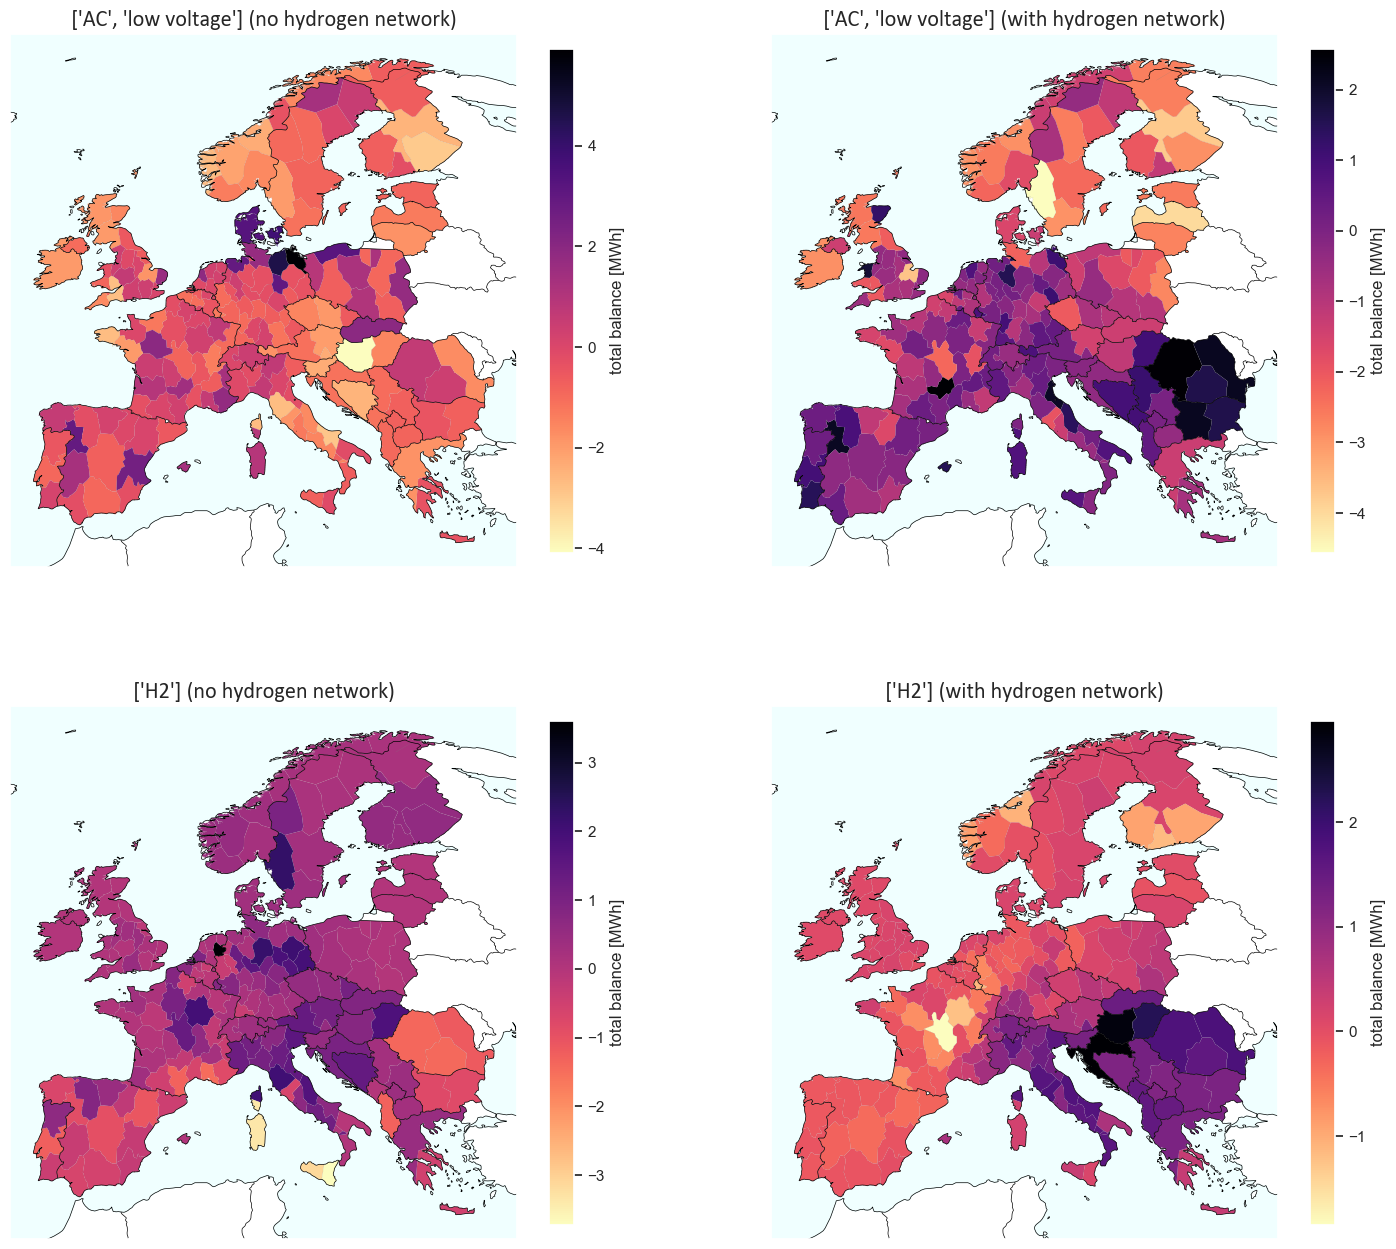

In [122]:
# nodal balance electricity and hydrogen
carrier_sets_plot = [["AC", "low voltage"], ["AC", "low voltage"], ["H2"], ["H2"]]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if i in [0,2]:
        df = df_no_ons
        title = "(no hydrogen network)"
    elif i in [1,3]:
        df = df_h2_ons
        title = "(with hydrogen network)"

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carrier_sets_plot[i]}_nb",
                                                   ax=ax,
                                                   cmap=plt.get_cmap("magma_r"),
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"total balance [MWh]",
                            'orientation': "vertical",
                                      'shrink' : 0.9})

    ax.set_title(f"{carrier_sets_plot[i]} {title}", fontsize=16, **font1)
plt.show()

In [89]:
# Figure 6 in Neumann paper
carrier = ["AC", "low voltage", "H2", "gas", "oil"]
nb = nodal_balance(n_h2, carrier=n_h2.buses.carrier.unique().tolist(), time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)

In [90]:
nb.describe()

count     182.000000
mean      355.205699
std       322.542205
min      -544.109260
25%       127.913871
50%       411.690449
75%       618.112881
max      1025.215984
dtype: float64

### Balance Flow

![](../../../../Pictures/Screenshots/Screenshot_20230215_101816.png)

In [141]:
n_no.lines_t.p0.sum()

Line
1     -1.187061e+06
10     8.523414e+06
100    4.419293e+06
101    9.065389e+05
102   -1.000031e+06
           ...     
95     9.479547e+05
96    -8.982532e+04
97     1.619466e+05
98     8.198081e+05
99    -1.042867e+06
Length: 323, dtype: float64

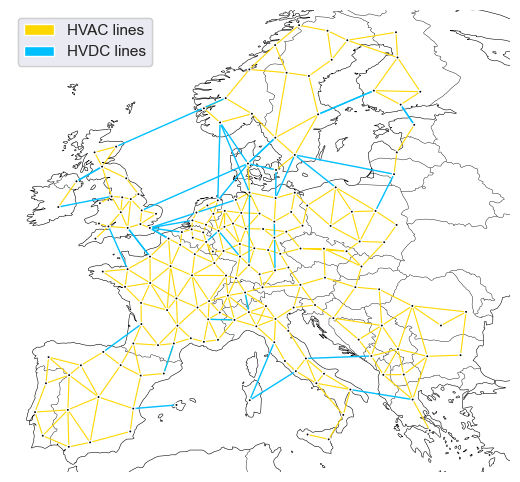

In [185]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

m_no.plot(ax=ax, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=0.8, link_widths=1)
pypsa.plot.add_legend_patches(ax=ax, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
plt.show()

In [147]:
locs = m_no.buses[m_no.buses.carrier == "AC"][["x","y"]]
locs

x          y
Bus                        
AL0 0  19.894573  41.561804
AT0 0  15.759790  47.898676
AT0 1  10.293250  47.248827
AT0 2  13.580650  47.413095
BA0 0  18.122704  43.811367
...          ...        ...
SE3 5  14.314407  63.302363
SE3 6  12.502502  57.969081
SE3 7  21.006840  66.234641
SI0 0  14.693952  46.071068
SK0 0  19.027888  48.653333

[181 rows x 2 columns]

# 4.2 Important Technologies and their role

## Electricity Balances

### Electricity balance (May)

In [91]:
carrier = ["AC", "low voltage"]
loads = ["electricity", "industry electricity", "agriculture electricity"]
period = "2013-05"
nb_el_no = nodal_balance(n_no, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
nb_el_h2 = nodal_balance(n_h2, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW and unstack
nb_el_no = nb_el_no.unstack(level=[1]) / 1000
nb_el_h2 = nb_el_h2.unstack(level=[1]) / 1000
loads_el_no = abs(nb_el_no[loads].sum(axis=1))
loads_el_h2 = abs(nb_el_h2[loads].sum(axis=1))
nb_el_no.drop(loads, axis=1, inplace=True)
nb_el_h2.drop(loads, axis=1, inplace=True)

# condense groups
nb_el_no = get_condense_sum(nb_el_no, c1_groups, c1_groups_name)
nb_el_h2 = get_condense_sum(nb_el_h2, c1_groups, c1_groups_name)
# rename unhandy column names
nb_el_no.rename(columns=carrier_renaming, inplace=True)
nb_el_h2.rename(columns=carrier_renaming, inplace=True)

nb_el_no.head(3)

carrier                        AC  BEV charger       DAC            DC  \
snapshot                                                                 
2013-05-01 00:00:00  1.728040e-14   -55.936232 -4.846786  1.364242e-15   
2013-05-01 03:00:00  7.275958e-15   -50.782888 -4.846752 -2.273737e-16   
2013-05-01 06:00:00  5.456968e-15  -352.207515 -4.846783  2.273737e-16   

carrier              H2 Electrolysis  H2 Fuel Cell        PHS        V2G  \
snapshot                                                                   
2013-05-01 00:00:00      -709.514501           NaN   4.023339  29.945463   
2013-05-01 03:00:00      -671.842886           NaN   7.678835  21.005248   
2013-05-01 06:00:00     -1932.708992           NaN -66.944392   7.030831   

carrier              battery charger  battery discharger  ...  solar rooftop  \
snapshot                                                  ...                  
2013-05-01 00:00:00        -0.997366          222.558061  ...            NaN   
2013-05-01 03:00:00        -0.124167          200.931540  ...       9.973257   
2013-05-01 06:00:00      -231.662255            0.682652  ...     243.879720   

carrier              gas CHP  gas CHP CC  biomass CHP CC  resistive heater  \
snapshot                                                                     
2013-05-01 00:00:00      NaN         NaN        2.601915         -1.135108   
2013-05-01 03:00:00      NaN         NaN       12.405591         -8.685297   
2013-05-01 06:00:00      NaN         NaN        0.005410        -28.003127   

carrier              gas boiler   heat pump  water tanks charger  \
snapshot                                                           
2013-05-01 00:00:00         0.0 -230.271011                  0.0   
2013-05-01 03:00:00         0.0 -303.697183                  0.0   
2013-05-01 06:00:00         0.0 -302.569416                  0.0   

carrier              water tanks discharger  solar thermal  
snapshot                                                    
2013-05-01 00:00:00                     0.0            0.0  
2013-05-01 03:00:00                     0.0            0.0  
2013-05-01 06:00:00                     0.0            0.0  

[3 rows x 28 columns]

In [92]:
# differences
nb_el_no.columns.difference(nb_el_h2.columns)

Index(['DAC', 'H2 Fuel Cell', 'gas CHP', 'gas CHP CC'], dtype='object', name='carrier')

- network without H2 grid has no 'biomass CHP'
- network with H2 grid has no Direct Air Capture, no H2 Fuel Cell, no gas CHP and no cas CHP CC

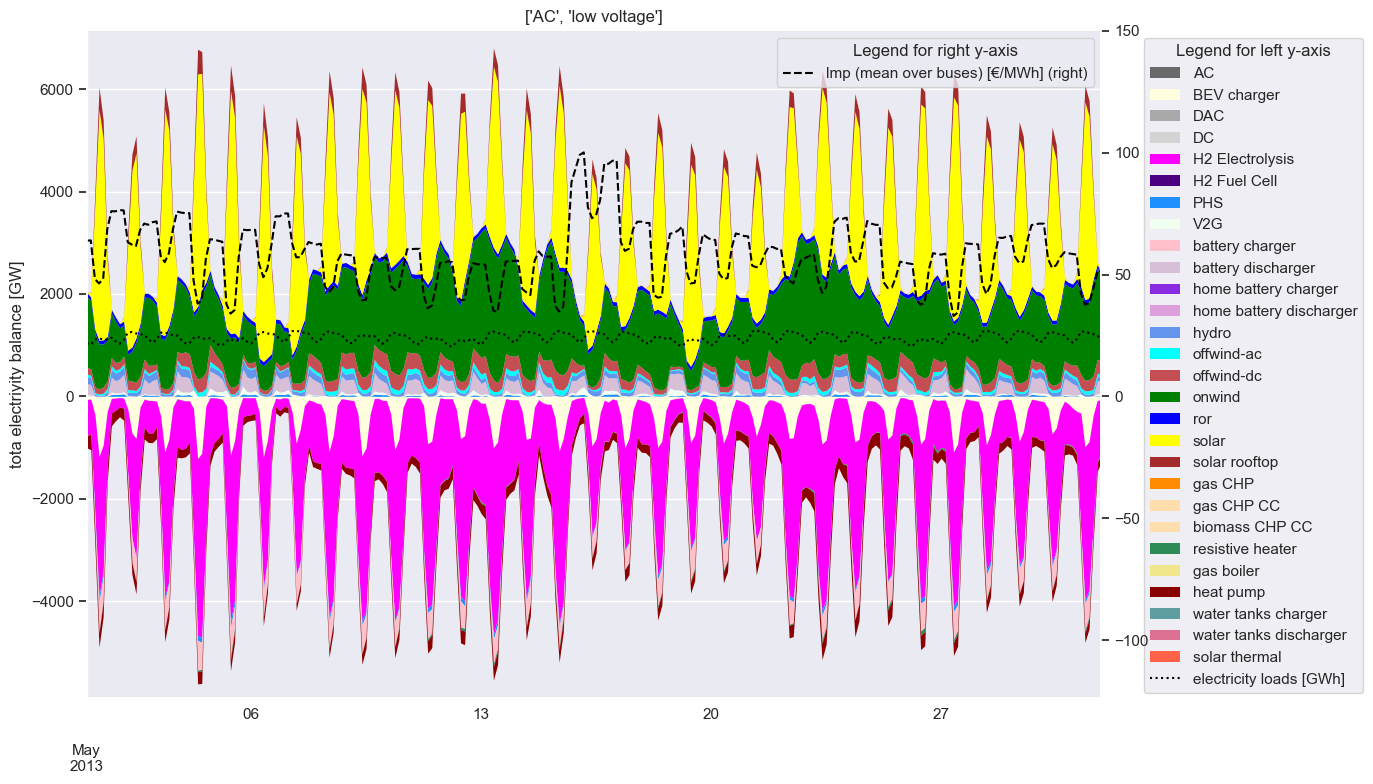

In [93]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_no
df = nb_el_no
df_loads = loads_el_no

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)
# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("tota electriyity balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

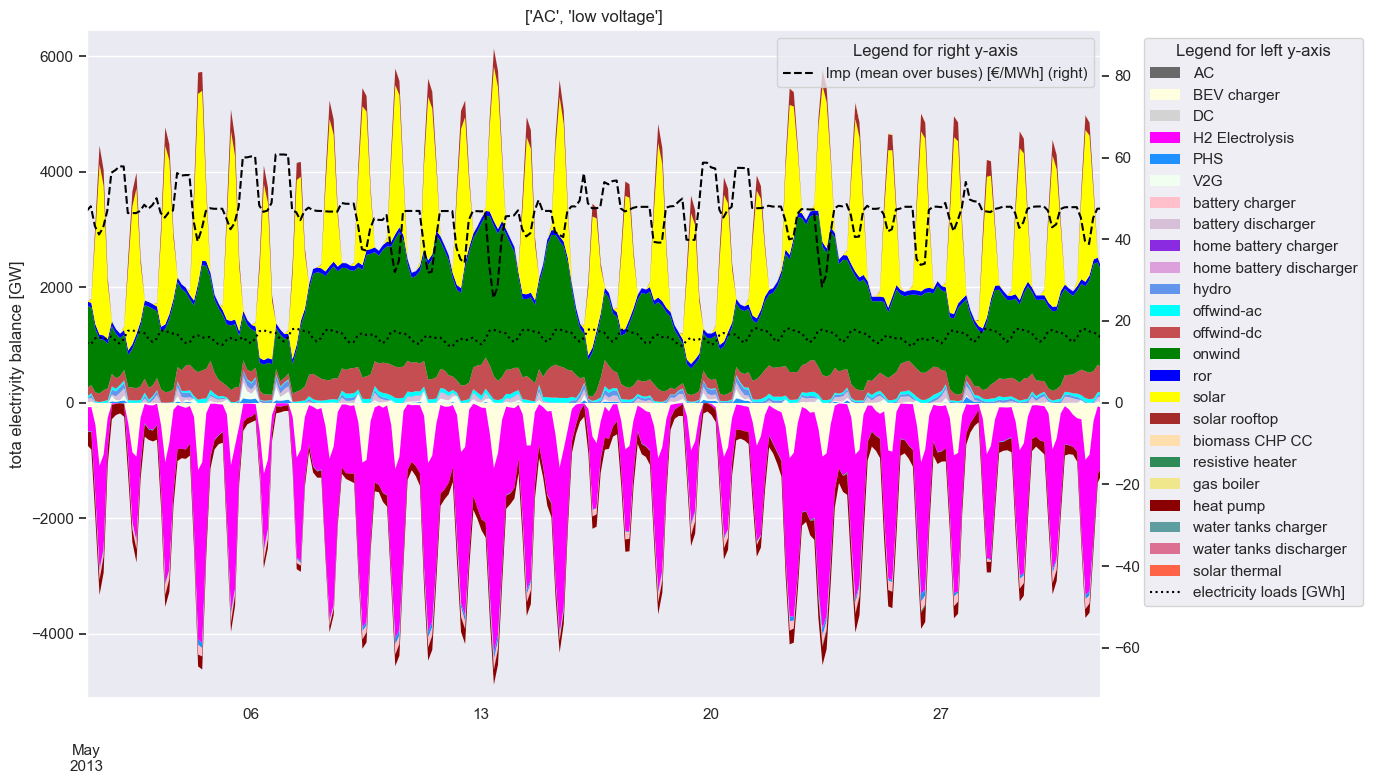

In [94]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_h2
df = nb_el_h2
df_loads = loads_el_h2

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)
# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("tota electriyity balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

### Electricity Balance (Jan)
Februar anschauen

In [95]:
carrier = ["AC", "low voltage"]
loads = ["electricity", "industry electricity", "agriculture electricity"]
period = "2013-01"
nb_el_no = nodal_balance(n_no, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
nb_el_h2 = nodal_balance(n_h2, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW and unstack
nb_el_no = nb_el_no.unstack(level=[1]) / 1000
nb_el_h2 = nb_el_h2.unstack(level=[1]) / 1000
loads_el_no = abs(nb_el_no[loads].sum(axis=1))
loads_el_h2 = abs(nb_el_h2[loads].sum(axis=1))
nb_el_no.drop(loads, axis=1, inplace=True)
nb_el_h2.drop(loads, axis=1, inplace=True)

# condense groups
nb_el_no = get_condense_sum(nb_el_no, c1_groups, c1_groups_name)
nb_el_h2 = get_condense_sum(nb_el_h2, c1_groups, c1_groups_name)
# rename unhandy column names
nb_el_no.rename(columns=carrier_renaming, inplace=True)
nb_el_h2.rename(columns=carrier_renaming, inplace=True)

nb_el_no.head(3)

carrier                        AC  BEV charger       DAC            DC  \
snapshot                                                                 
2013-01-01 00:00:00  1.182343e-14  -471.667750 -4.701310  1.818989e-15   
2013-01-01 03:00:00  1.455192e-14  -339.458588 -4.701299 -2.728484e-15   
2013-01-01 06:00:00 -2.182787e-14  -459.324499 -4.701317  2.273737e-15   

carrier              H2 Electrolysis  H2 Fuel Cell  OCGT       PHS       V2G  \
snapshot                                                                       
2013-01-01 00:00:00     -2086.685643           NaN   NaN -8.191668  5.377617   
2013-01-01 03:00:00     -1902.041094           NaN   NaN  2.064618  7.421831   
2013-01-01 06:00:00     -1845.437240           NaN   NaN -9.096095  1.615203   

carrier              battery charger  ...  solar rooftop    gas CHP  \
snapshot                              ...                             
2013-01-01 00:00:00       -27.560361  ...            NaN  26.784181   
2013-01-01 03:00:00       -30.929961  ...            NaN  42.072599   
2013-01-01 06:00:00      -102.300655  ...      52.107755   7.057945   

carrier              gas CHP CC  biomass CHP CC  resistive heater  gas boiler  \
snapshot                                                                        
2013-01-01 00:00:00    0.002446       72.685865        -50.220569         0.0   
2013-01-01 03:00:00    0.002457       73.037867       -218.312261         0.0   
2013-01-01 06:00:00    0.002455       73.186171       -273.810208         0.0   

carrier               heat pump  water tanks charger  water tanks discharger  \
snapshot                                                                       
2013-01-01 00:00:00 -403.124125                  0.0                     0.0   
2013-01-01 03:00:00 -488.455926                  0.0                     0.0   
2013-01-01 06:00:00 -498.409860                  0.0                     0.0   

carrier              solar thermal  
snapshot                            
2013-01-01 00:00:00            0.0  
2013-01-01 03:00:00            0.0  
2013-01-01 06:00:00            0.0  

[3 rows x 29 columns]

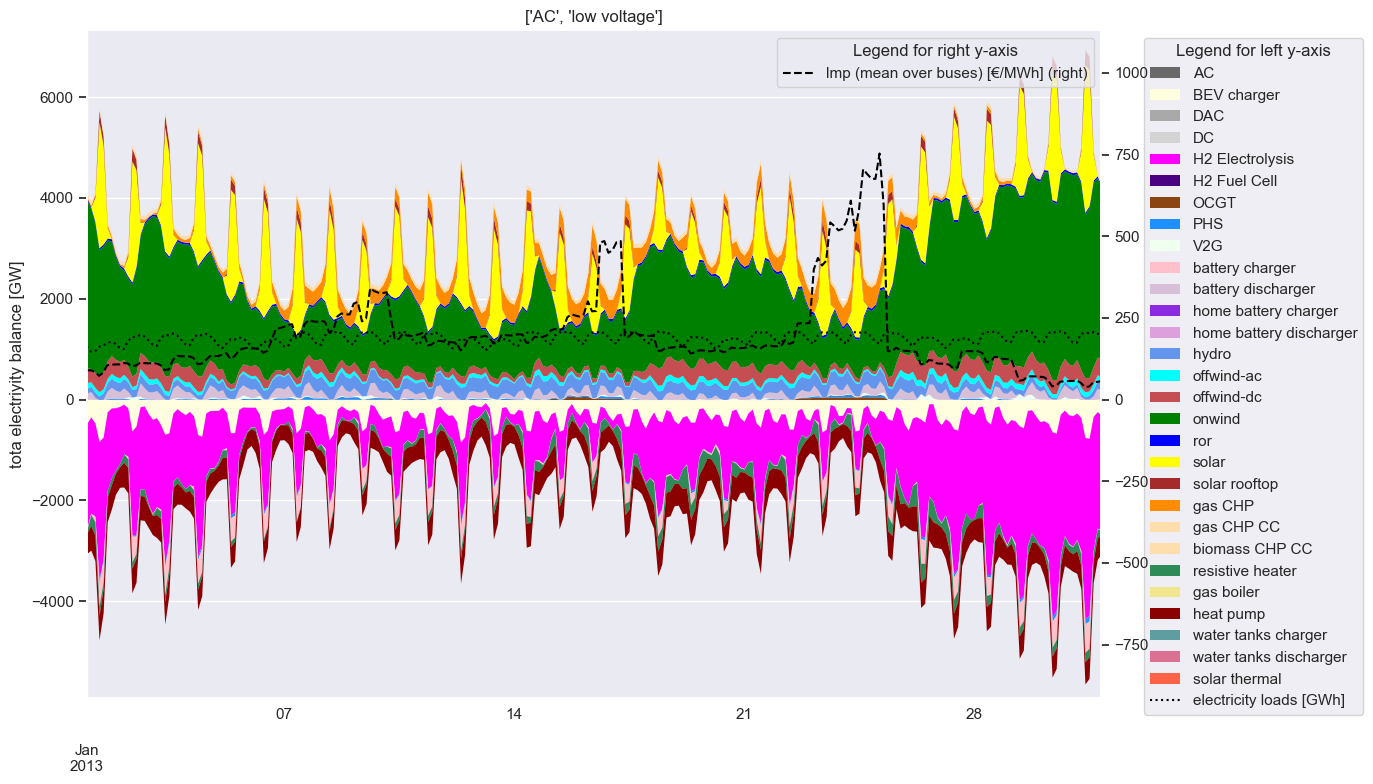

In [96]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_no
df = nb_el_no
df_loads = loads_el_no

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)
# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("tota electriyity balance [GW]")
ax.set_xlabel("")
ax.grid(True)
ax.set_title(f"{carrier}")
fig.tight_layout()

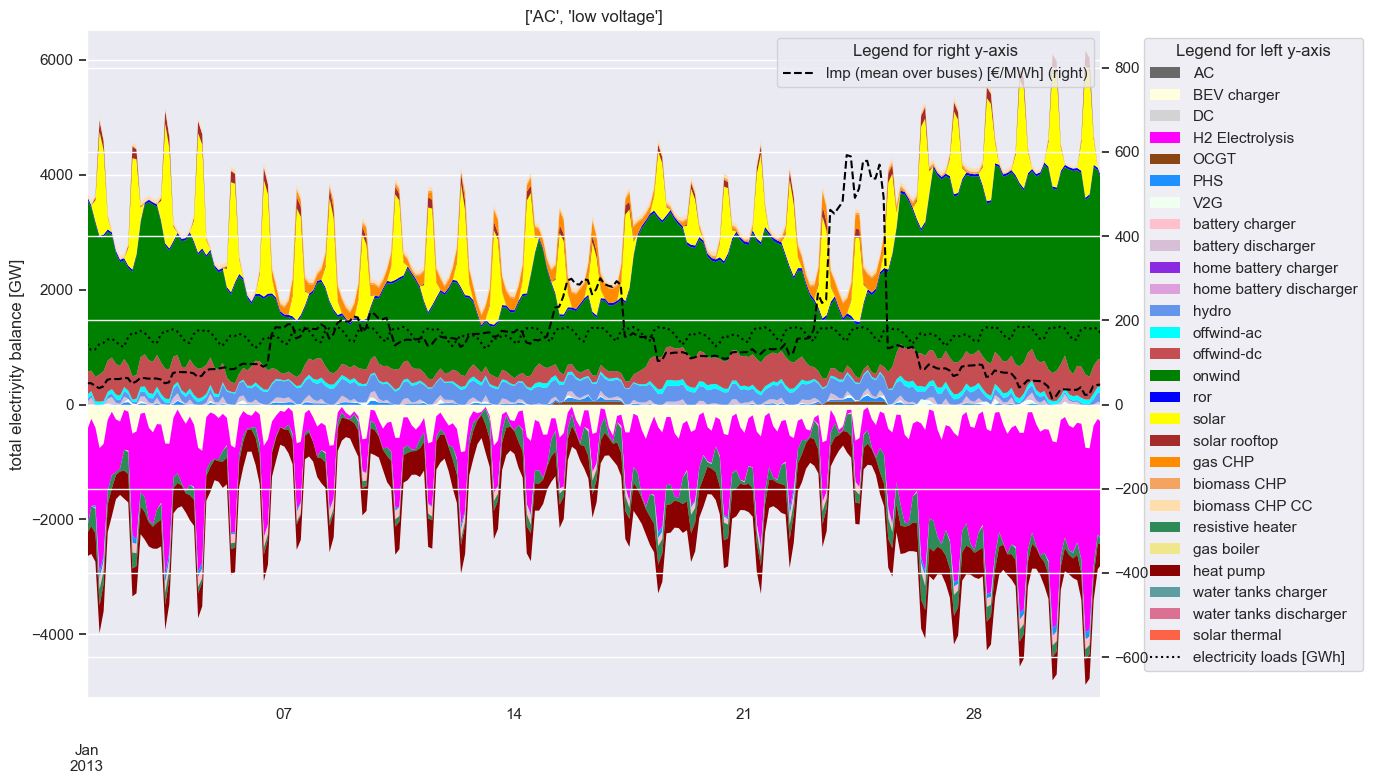

In [97]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_h2
df = nb_el_h2
df_loads = loads_el_h2

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)

# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("total electriyity balance [GW]")
ax.set_xlabel("")
ax.grid(True)
ax.set_title(f"{carrier}")
fig.tight_layout()

### Electricity balance (all year)

In [98]:
carrier = ["AC", "low voltage"]
loads = ["electricity", "industry electricity", "agriculture electricity"]
period = "2013"
nb_el_no = nodal_balance(n_no, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
nb_el_h2 = nodal_balance(n_h2, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW and unstack
nb_el_no = nb_el_no.unstack(level=[1]) / 1000
nb_el_h2 = nb_el_h2.unstack(level=[1]) / 1000
loads_el_no = abs(nb_el_no[loads].sum(axis=1))
loads_el_h2 = abs(nb_el_h2[loads].sum(axis=1))
nb_el_no.drop(loads, axis=1, inplace=True)
nb_el_h2.drop(loads, axis=1, inplace=True)

# condense groups
nb_el_no_all = get_condense_sum(nb_el_no, c1_groups, c1_groups_name)
nb_el_h2_all = get_condense_sum(nb_el_h2, c1_groups, c1_groups_name)
# rename unhandy column names
nb_el_no_all.rename(columns=carrier_renaming, inplace=True)
nb_el_h2_all.rename(columns=carrier_renaming, inplace=True)

nb_el_no_all.head(3)

carrier                        AC  BEV charger       DAC            DC  \
snapshot                                                                 
2013-01-01 00:00:00  1.182343e-14  -471.667750 -4.701310  1.818989e-15   
2013-01-01 03:00:00  1.455192e-14  -339.458588 -4.701299 -2.728484e-15   
2013-01-01 06:00:00 -2.182787e-14  -459.324499 -4.701317  2.273737e-15   

carrier              H2 Electrolysis  H2 Fuel Cell  OCGT       PHS       V2G  \
snapshot                                                                       
2013-01-01 00:00:00     -2086.685643           NaN   NaN -8.191668  5.377617   
2013-01-01 03:00:00     -1902.041094           NaN   NaN  2.064618  7.421831   
2013-01-01 06:00:00     -1845.437240           NaN   NaN -9.096095  1.615203   

carrier              battery charger  ...  solar rooftop    gas CHP  \
snapshot                              ...                             
2013-01-01 00:00:00       -27.560361  ...            NaN  26.784181   
2013-01-01 03:00:00       -30.929961  ...            NaN  42.072599   
2013-01-01 06:00:00      -102.300655  ...      52.107755   7.057945   

carrier              gas CHP CC  biomass CHP CC  resistive heater  gas boiler  \
snapshot                                                                        
2013-01-01 00:00:00    0.002446       72.685865        -50.220569         0.0   
2013-01-01 03:00:00    0.002457       73.037867       -218.312261         0.0   
2013-01-01 06:00:00    0.002455       73.186171       -273.810208         0.0   

carrier               heat pump  water tanks charger  water tanks discharger  \
snapshot                                                                       
2013-01-01 00:00:00 -403.124125                  0.0                     0.0   
2013-01-01 03:00:00 -488.455926                  0.0                     0.0   
2013-01-01 06:00:00 -498.409860                  0.0                     0.0   

carrier              solar thermal  
snapshot                            
2013-01-01 00:00:00            0.0  
2013-01-01 03:00:00            0.0  
2013-01-01 06:00:00            0.0  

[3 rows x 29 columns]

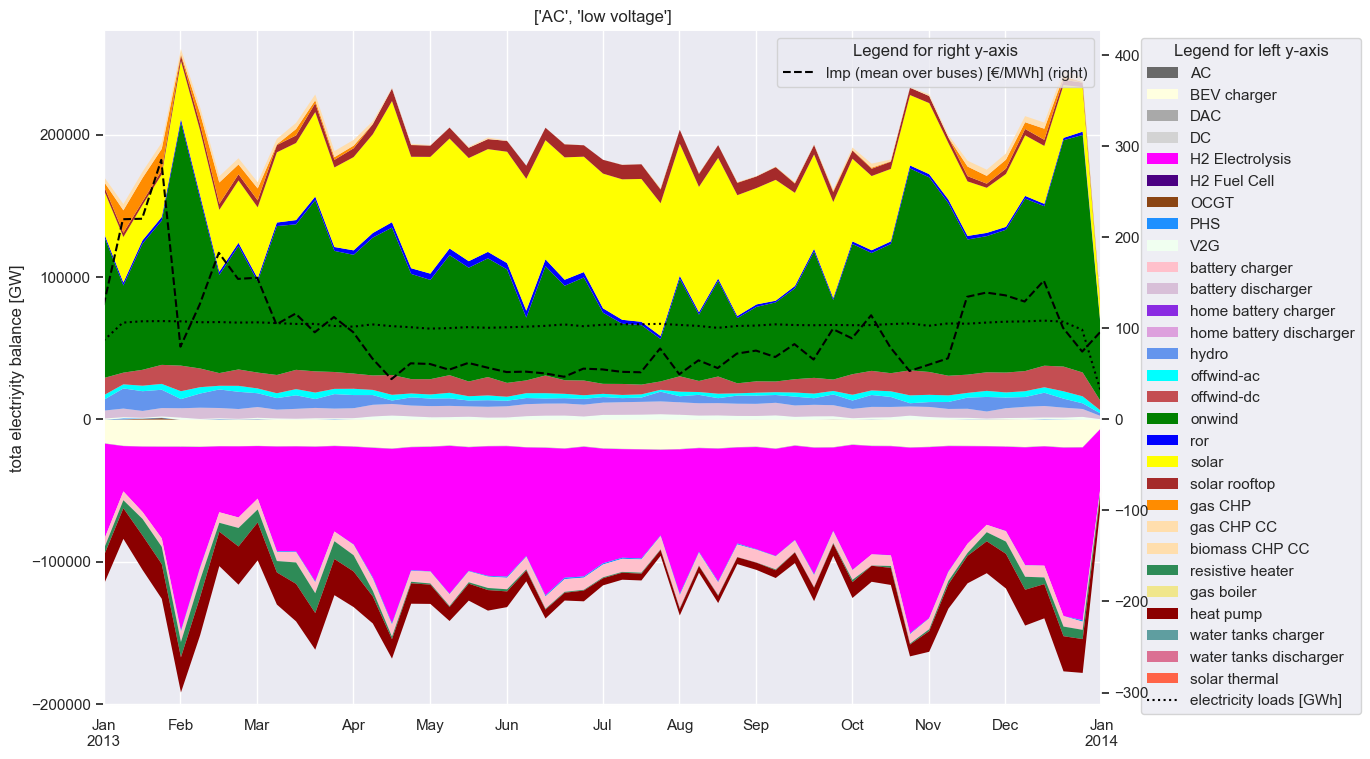

In [99]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_no
# "8h", "D", "W", "M"
res = "W"
df = nb_el_no_all.resample(res).sum()
df_loads = loads_el_no.resample(res).sum()

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period].resample(res).mean()
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("tota electriyity balance [GW]")
ax.set_xlabel("")
ax.grid(True)
ax.set_title(f"{carrier}")
fig.tight_layout()

In [100]:
# get list of months
month_list = pd.period_range(start='2013-01-01', end='2013-12-31', freq='M')
month_list = [month.strftime("%b-%Y") for month in month_list]

res_no_all_pos = pd.DataFrame(index=month_list, columns= nb_el_no_all.columns)
res_no_all_neg = pd.DataFrame(index=month_list, columns= nb_el_no_all.columns)
res_h2_all_pos = pd.DataFrame(index=month_list, columns= nb_el_h2_all.columns)
res_h2_all_neg = pd.DataFrame(index=month_list, columns= nb_el_h2_all.columns)

iterables = [month_list, ["no H2 network", "H2 network"]]
multiindex = pd.MultiIndex.from_product(iterables, names=["month", "scenario"])
index_union = nb_el_no_all.columns.union(nb_el_h2_all.columns)
res_pos = pd.DataFrame(index=multiindex, columns=index_union)
res_neg = pd.DataFrame(index=multiindex, columns=index_union)

df_no_neg, df_no_pos = nb_el_no_all.clip(upper=0), nb_el_no_all.clip(lower=0)
df_h2_neg, df_h2_pos = nb_el_h2_all.clip(upper=0), nb_el_h2_all.clip(lower=0)

for month in month_list:
    res_no_all_pos.loc[month] = df_no_pos[month].sum()
    res_no_all_neg.loc[month] = df_no_neg[month].sum()
    res_h2_all_pos.loc[month] = df_h2_pos[month].sum()
    res_h2_all_neg.loc[month] = df_h2_neg[month].sum()

    res_pos.loc[month, "no H2 network"] = df_no_pos[month].sum()
    res_pos.loc[month, "H2 network"] = df_h2_pos[month].sum()
    res_neg.loc[month, "no H2 network"] = df_no_neg[month].sum()
    res_neg.loc[month, "H2 network"] = df_h2_neg[month].sum()

<Figure size 2000x800 with 0 Axes>

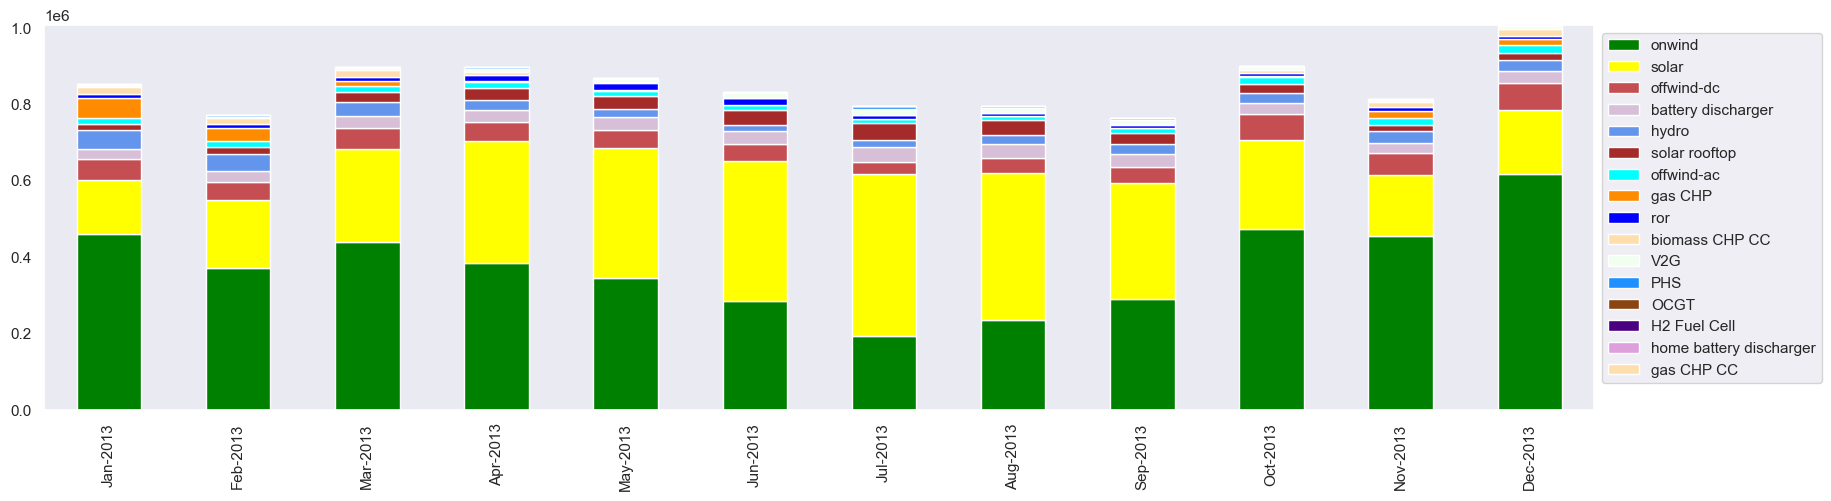

In [101]:
# sort carriers by ouptut and exclude all with less than 1 GW
i_no_gen = res_no_all_pos.sum().sort_values(ascending=False)[res_no_all_pos.sum().sort_values(ascending=False) > 1].index

fig = plt.figure(figsize=(20, 8))
res_no_all_pos[i_no_gen].plot(kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_no_all_pos[i_no_gen].columns])
plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.show()

<Figure size 2000x800 with 0 Axes>

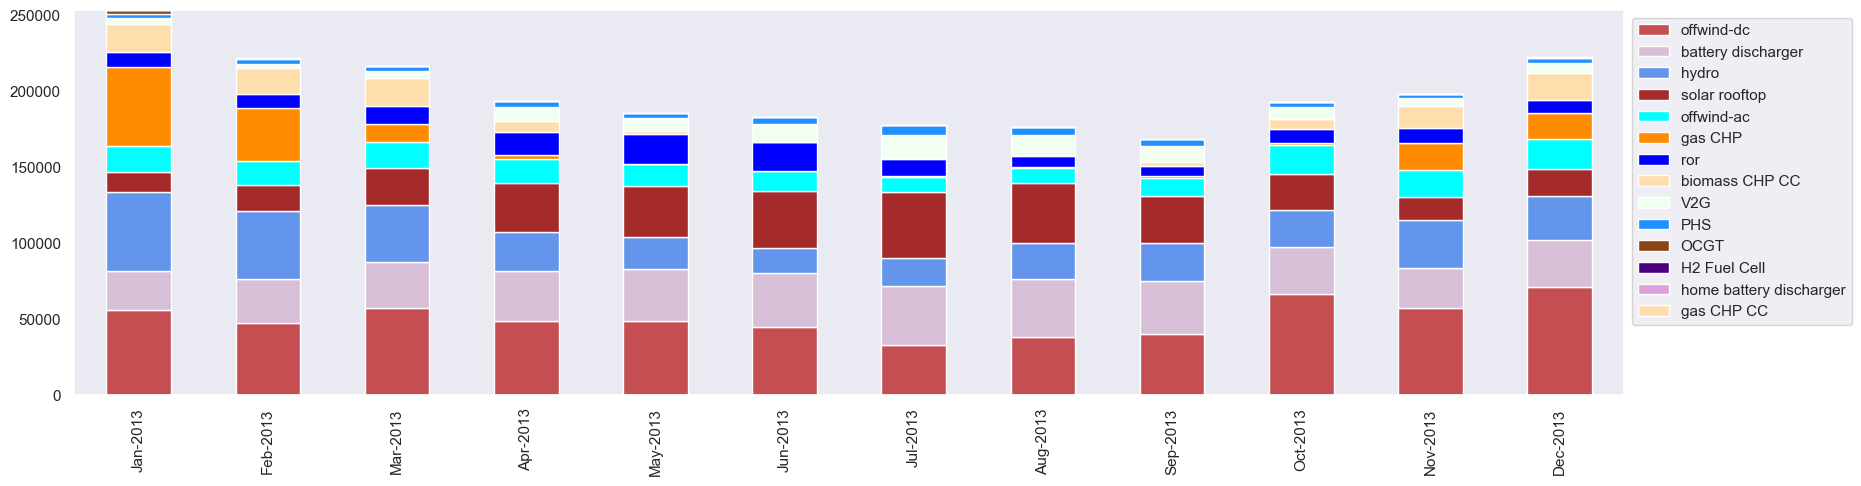

In [102]:
# exclude solar and onwind
i_no_gen_ex = i_no_gen.drop(["onwind", "solar"])

fig = plt.figure(figsize=(20, 8))
res_no_all_pos[i_no_gen_ex].plot(kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_pos[i_no_gen_ex].columns])
plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.show()

<Figure size 2000x800 with 0 Axes>

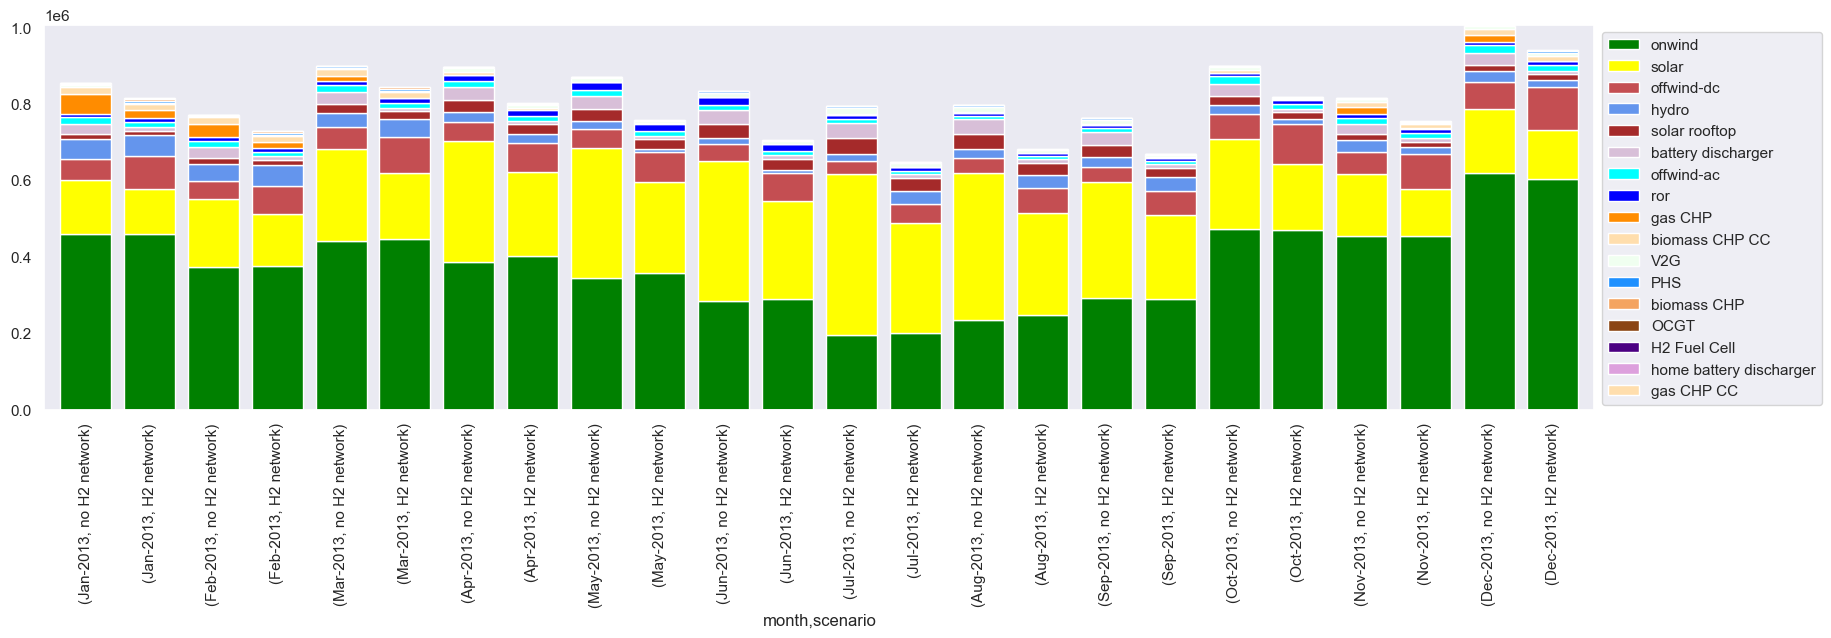

In [103]:
# sort carriers by ouptut and exclude all with less than 1 GW
index = res_pos.sum().sort_values(ascending=False)[res_pos.sum().sort_values(ascending=False) > 1].index

fig = plt.figure(figsize=(20, 8))
res_pos[index].plot(kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_pos[index].columns], width=0.8)
plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.show()

<Figure size 2000x800 with 0 Axes>

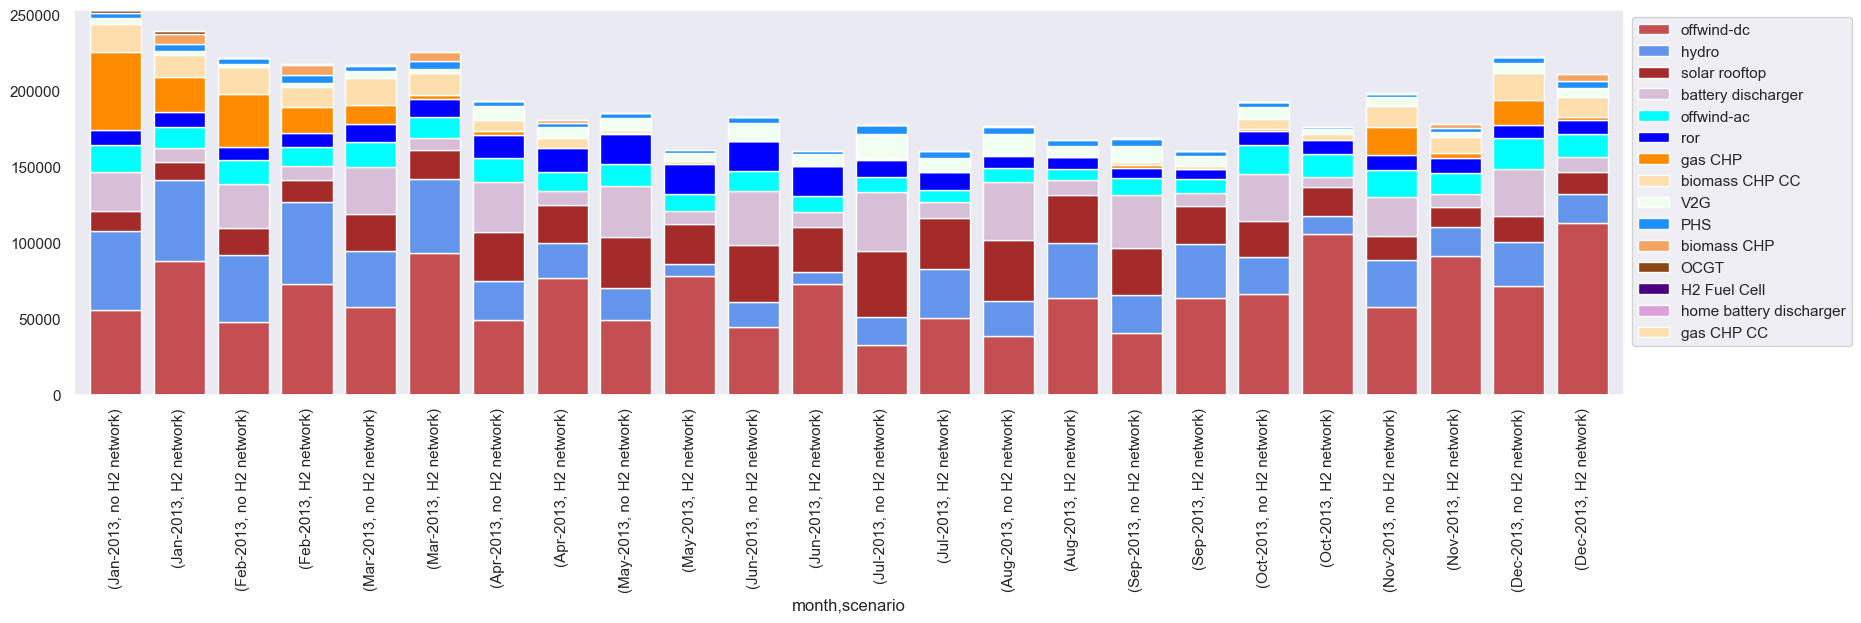

In [104]:
# exclude solar and onwind
index = index.drop(["onwind", "solar"])

fig = plt.figure(figsize=(20, 8))
res_pos[index].plot(kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_pos[index].columns], width=0.8)
plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.show()

In [105]:
abs(res_no_all_neg.sum()).sort_values(ascending=False)[abs(res_no_all_neg.sum()).sort_values(ascending=False) > 1].index

Index(['H2 Electrolysis', 'BEV charger', 'heat pump', 'battery charger',
       'resistive heater', 'PHS', 'DAC', 'home battery charger'],
      dtype='object', name='carrier')

<Figure size 2000x800 with 0 Axes>

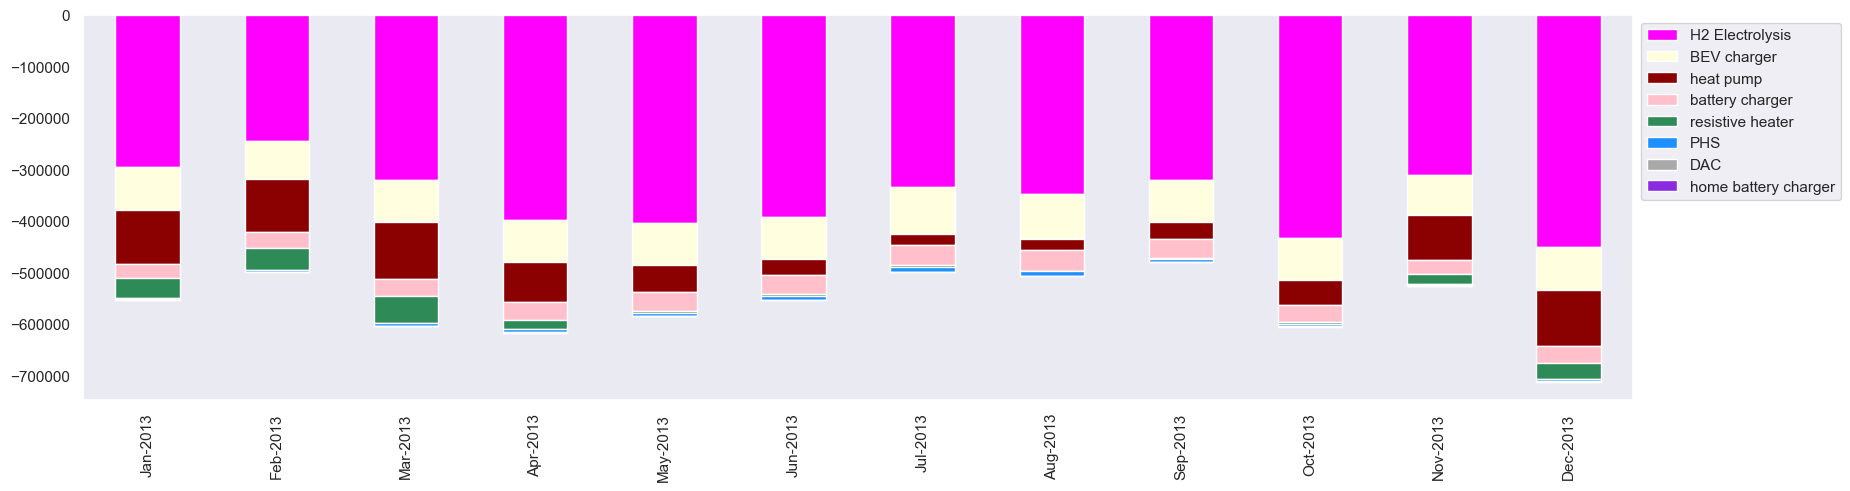

In [106]:
# sort carriers by consumption and exclude all with less than 1 GW
i_no_con = abs(res_no_all_neg.sum()).sort_values(ascending=False)[abs(res_no_all_neg.sum()).sort_values(ascending=False) > 1].index

fig = plt.figure(figsize=(20, 8))
res_no_all_neg[i_no_con].plot(kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_no_all_neg[i_no_con].columns])
plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.show()

<Figure size 2000x800 with 0 Axes>

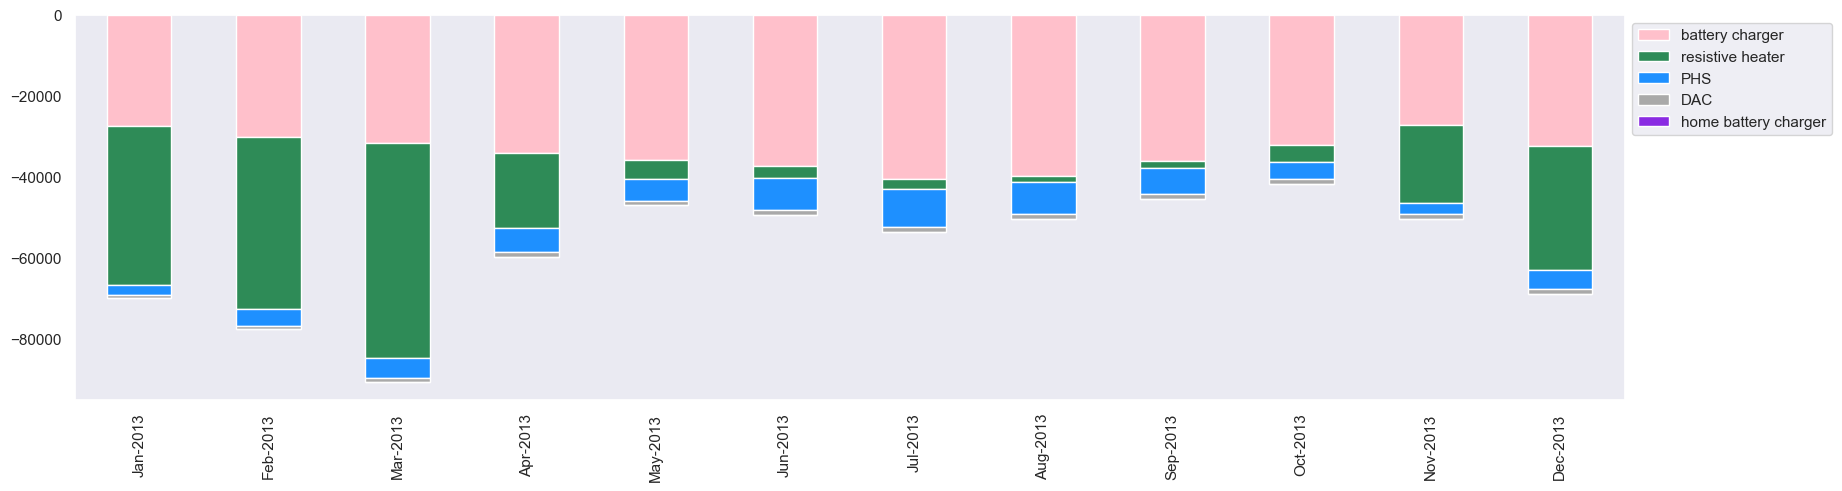

In [107]:
# exclude
i_no_con_ex = i_no_con.drop(["H2 Electrolysis", "BEV charger", "heat pump"])

fig = plt.figure(figsize=(20, 8))
res_no_all_neg[i_no_con_ex].plot(kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_no_all_neg[i_no_con_ex].columns])
plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.show()

<Figure size 2000x800 with 0 Axes>

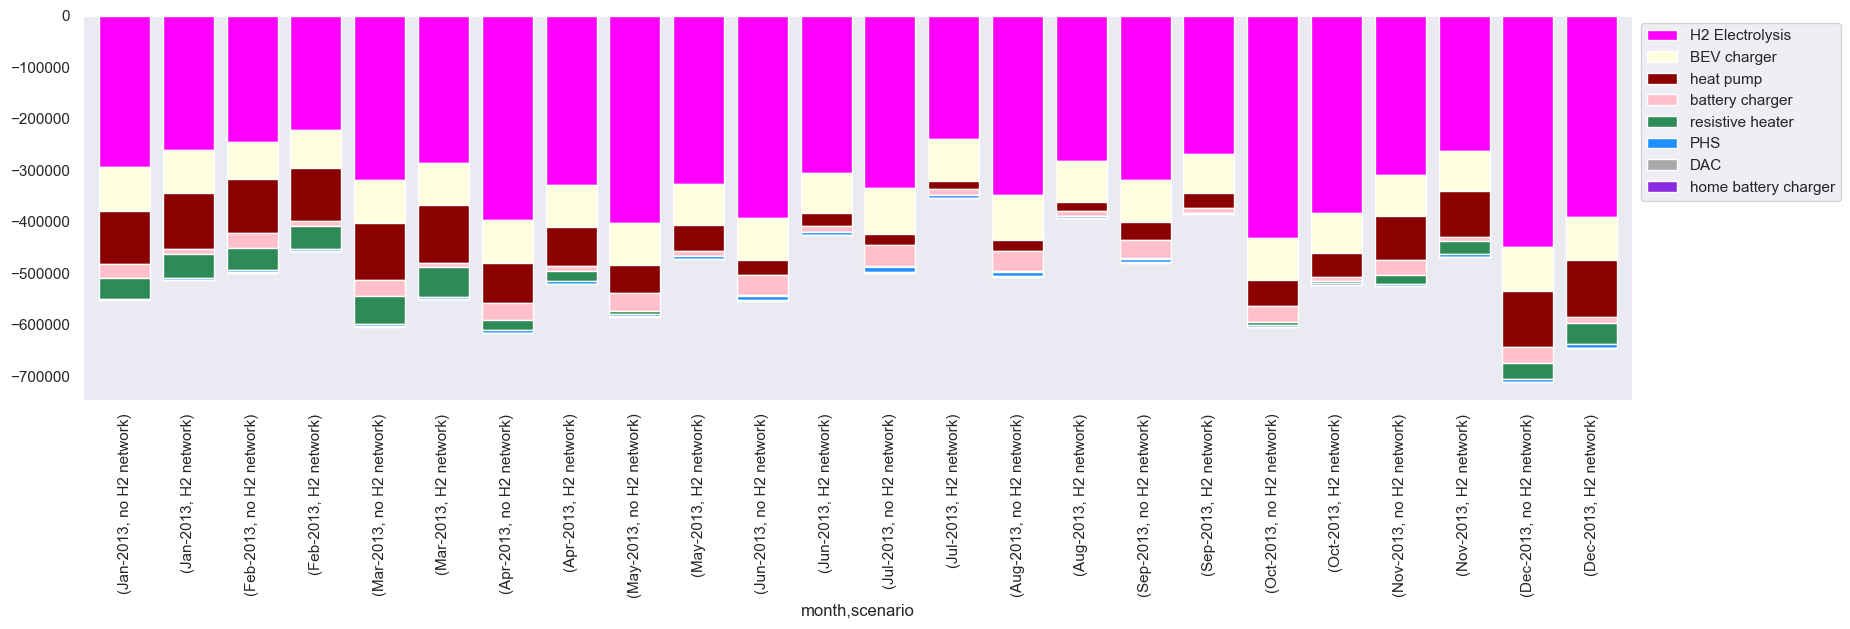

In [108]:
# sort carriers by ouptut and exclude all with less than 1 GW
index = abs(res_neg.sum()).sort_values(ascending=False)[abs(res_neg.sum()).sort_values(ascending=False) > 1].index

fig = plt.figure(figsize=(20, 8))
res_neg[index].plot(kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_neg[index].columns], width=0.8)
plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.show()

<Figure size 2000x800 with 0 Axes>

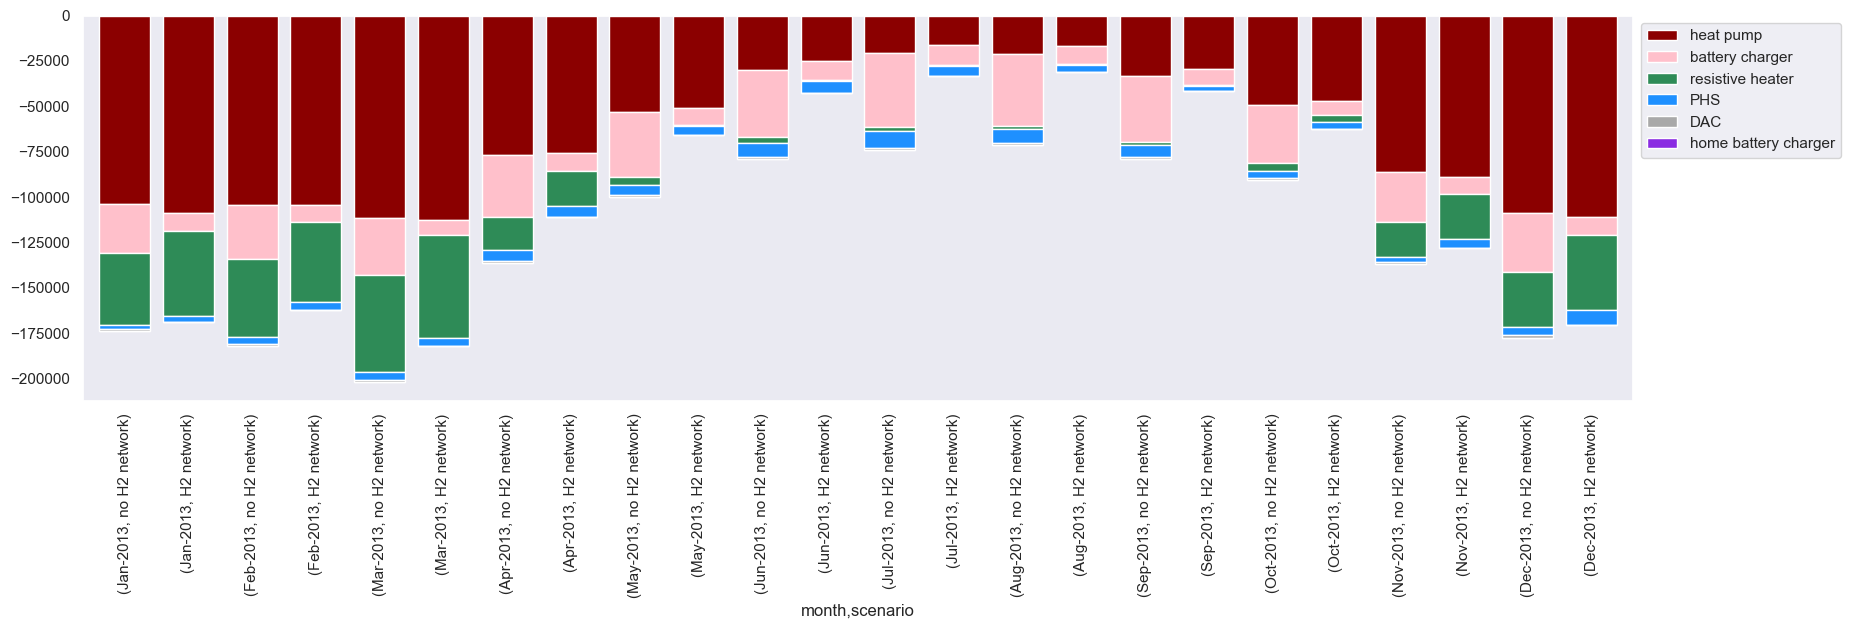

In [109]:
# exclude
index = index.drop(["H2 Electrolysis", "BEV charger"])

fig = plt.figure(figsize=(20, 8))
res_neg[index].plot(kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_neg[index].columns], width=0.8)
plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.show()

## Capacity factors, load duration curves

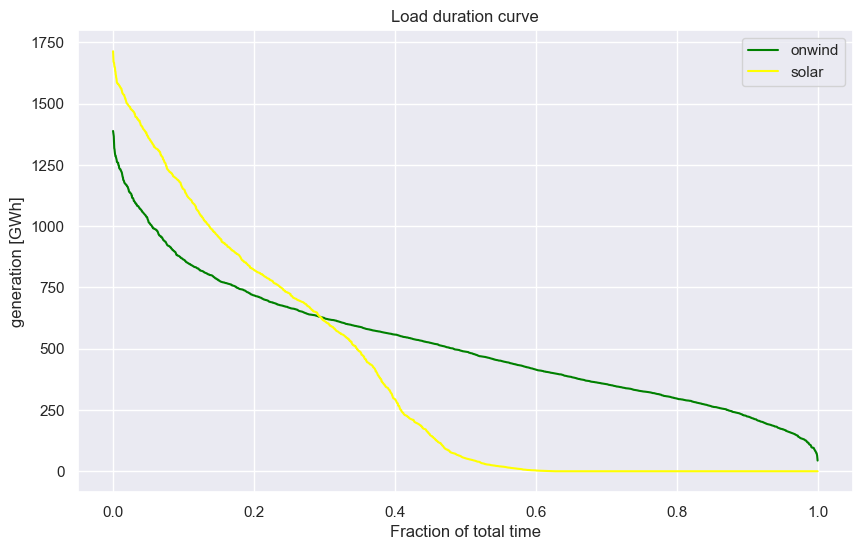

In [110]:
fig = plt.figure(figsize=(10, 6))
n = n_no

for c in ["onwind", "solar"]:
    gen = n.generators_t.p.loc[:, n.generators.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c)

plt.title("Load duration curve")
plt.ylabel("generation [GWh]")
plt.xlabel("Fraction of total time")
plt.legend()
plt.show()

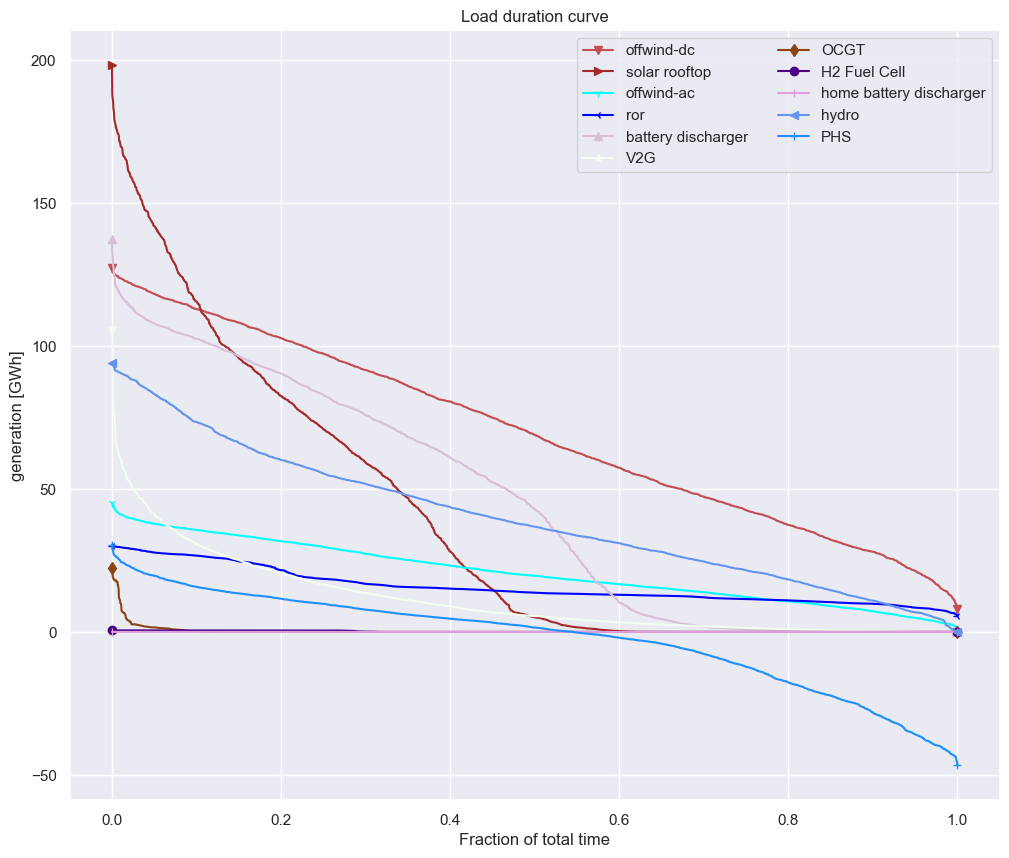

In [111]:
index = list(i_no_gen_ex)
n = n_no

fig = plt.figure(figsize=(12, 10))

for c in c_gen(index, n_no):
    gen = n.generators_t.p.loc[:, n.generators.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c, marker=markers[index.index(c)], markevery=[0,-1])

for c in c_link(index, n_no):
    gen = -n.links_t.p1.loc[:, n.links.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c,marker=markers[index.index(c)], markevery=[0,-1])

for c in c_su(index, n_no):
    gen = n.storage_units_t.p.loc[:, n.storage_units.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c, marker=markers[index.index(c)], markevery=[0,-1])

plt.title("Load duration curve")
plt.ylabel("generation [GWh]")
plt.xlabel("Fraction of total time")
plt.legend(ncol=2)
plt.show()

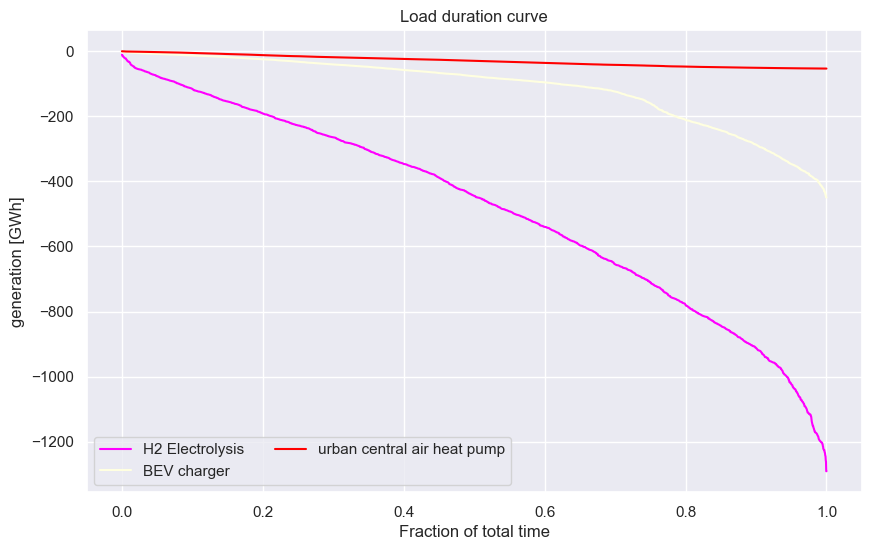

In [112]:
index = ["H2 Electrolysis", "BEV charger"] + ["urban central air heat pump"] #heat_pump # heat pump is missing due to grouping
fig = plt.figure(figsize=(10, 6))

for c in c_gen(index, n_no):
    gen = n.generators_t.p.loc[:, n.generators.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c)

for c in c_link(index, n_no):
    gen = -n.links_t.p0.loc[:, n.links.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c)

for c in c_su(index, n_no):
    gen = n.storage_units_t.p.loc[:, n.storage_units.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c)

plt.title("Load duration curve")
plt.ylabel("generation [GWh]")
plt.xlabel("Fraction of total time")
plt.legend(ncol=2)
plt.show()

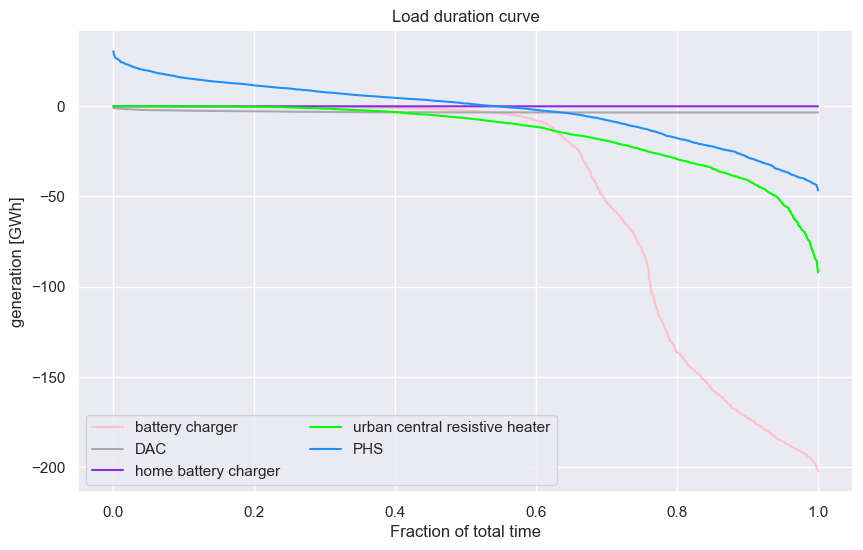

In [113]:
index = list(i_no_con_ex) + ["urban central resistive heater"] #resistive_heater # resistive heater is missing due to grouping
fig = plt.figure(figsize=(10, 6))

for c in c_gen(index, n_no):
    gen = n.generators_t.p.loc[:, n.generators.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c)

for c in c_link(index, n_no):
    gen = -n.links_t.p0.loc[:, n.links.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c)

for c in c_su(index, n_no):
    gen = n.storage_units_t.p.loc[:, n.storage_units.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    plt.plot(gen, color = carrier_colors[c], label=c)

plt.title("Load duration curve")
plt.ylabel("generation [GWh]")
plt.xlabel("Fraction of total time")
plt.legend(ncol=2)
plt.show()

Questions:
- Does it make more sense for the consuming carriers to look at p0 or p1? just difference in magnitude and sign

Findings

### Capacity factors

In [114]:
carrier_renaming_reverse = {
'biomass CHP CC': 'urban central solid biomass CHP CC',
'biomass CHP' :'urban central solid biomass CHP' ,
'gas CHP': 'urban central gas CHP' ,
'gas CHP CC' : 'urban central gas CHP CC'
}

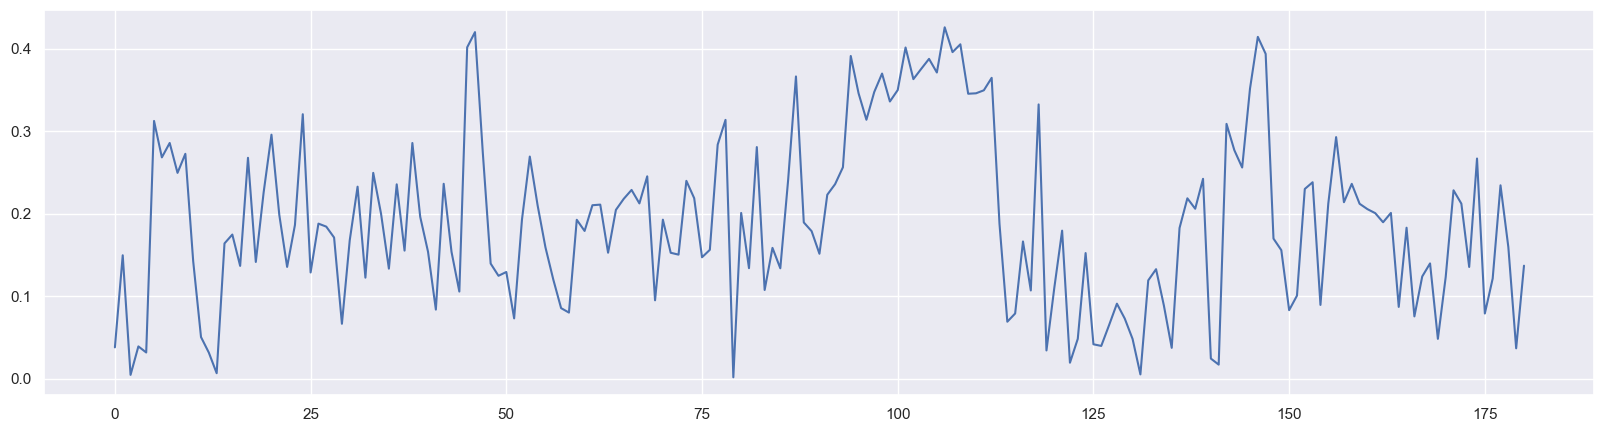

In [115]:
c = "onwind"
plt.plot(df_no_ons[f"{c}_cf"].values)

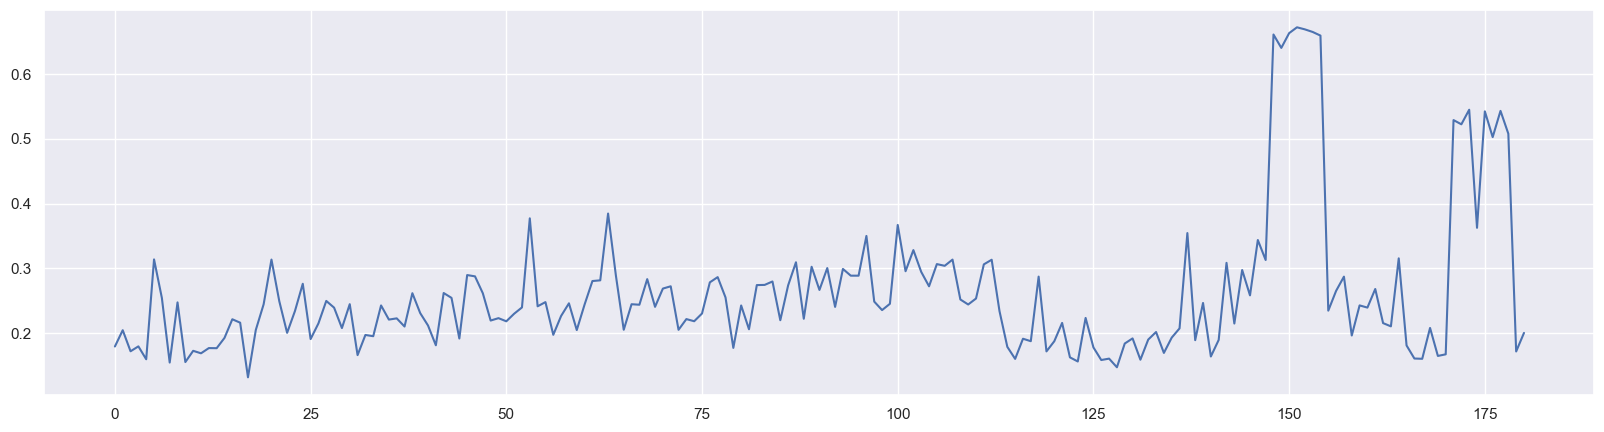

In [116]:
c = "H2 Electrolysis"
plt.plot(df_no_ons[f"{c}_cf"].values)

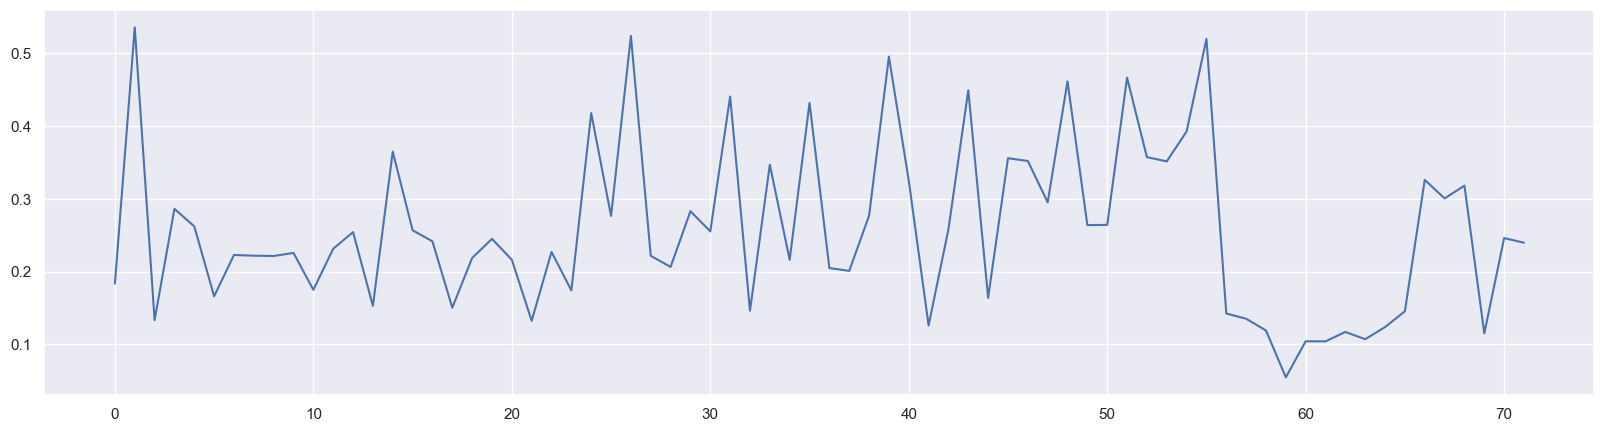

In [117]:
c = "PHS"
plt.plot(df_no_ons[f"{c}_cf"].dropna().values)

In [196]:
i_no_gen_rev

['onwind',
 'solar',
 'offwind-dc',
 'battery discharger',
 'hydro',
 'solar rooftop',
 'offwind-ac',
 'urban central gas CHP',
 'ror',
 'urban central solid biomass CHP CC',
 'V2G',
 'PHS',
 'OCGT',
 'H2 Fuel Cell',
 'home battery discharger',
 'urban central gas CHP CC']

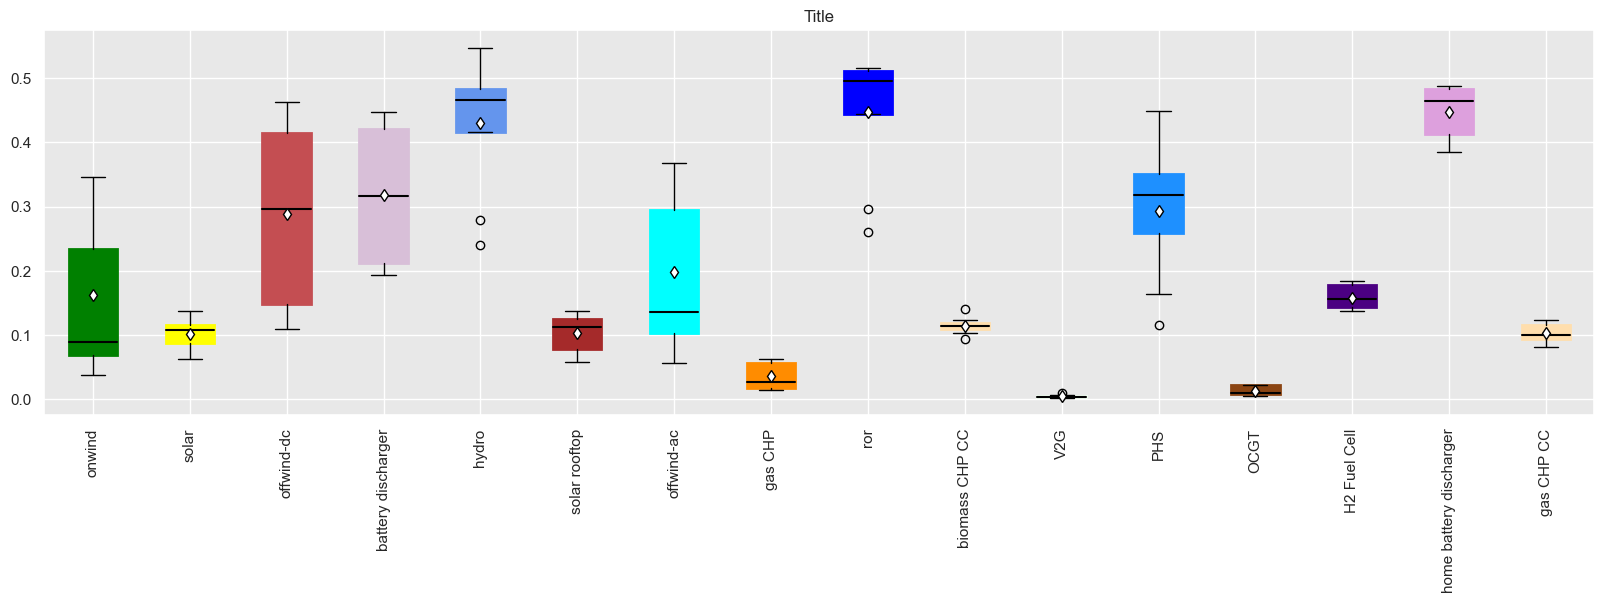

In [235]:
# capacity factors
boxprops=dict(facecolor="white", color="white")
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}

i_no_gen_rev = [carrier_renaming_reverse.get(n, n) for n in i_no_gen]
df = df_no_ons[[f"{i}_cf" for i in i_no_gen_rev]]

fig, ax = plt.subplots()
bp = plt.boxplot(x=df.dropna(), labels =i_no_gen, patch_artist=True, showmeans=True, boxprops=boxprops, meanprops=meanprops, medianprops=medianprops)

for box, col in zip(bp['boxes'],[carrier_colors[c] for c in i_no_gen]):
    # change outline color
    box.set(color=col, linewidth=2)

plt.title("Title")
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)
plt.xticks(rotation=90)
plt.show()

![](../../../../Pictures/Screenshots/Screenshot2023-03-07_152126.png)

In [243]:
carrier = "onwind"
n.generators_t.p.loc[:, n.generators.carrier == carrier]

Generator            AL0 0 onwind  AT0 0 onwind  AT0 1 onwind  AT0 2 onwind  \
snapshot                                                                      
2013-01-01 00:00:00      0.000000   4917.113011      0.000160      0.000317   
2013-01-01 03:00:00      0.000000   4623.535568      0.000105      0.000000   
2013-01-01 06:00:00      0.000000   3455.948969      0.000061      0.000000   
2013-01-01 09:00:00      0.000000   1471.522842      0.000000      0.000000   
2013-01-01 12:00:00      0.000000    497.291894      0.000000      0.000000   
...                           ...           ...           ...           ...   
2013-12-31 09:00:00      0.000000    448.489909      0.000000      0.000000   
2013-12-31 12:00:00      0.000000   1290.876086      0.000000      0.000000   
2013-12-31 15:00:00      0.000000   1932.721807      0.000000      0.000000   
2013-12-31 18:00:00      0.000551   3046.962171      0.000000      0.000676   
2013-12-31 21:00:00      0.000649   3613.135660      0.000088      0.000521   

Generator            BA0 0 onwind  BE0 0 onwind  BE0 1 onwind  BE0 2 onwind  \
snapshot                                                                      
2013-01-01 00:00:00           0.0   3093.083953   8168.950405   1295.137103   
2013-01-01 03:00:00           0.0   1958.927601   8093.797510   1134.076875   
2013-01-01 06:00:00           0.0   1633.056468   6837.794781    817.427146   
2013-01-01 09:00:00           0.0   1665.955722   5650.347264    826.866528   
2013-01-01 12:00:00           0.0   1320.283662   5547.281976    580.886231   
...                           ...           ...           ...           ...   
2013-12-31 09:00:00           0.0   2801.105630   5810.037940   1186.692921   
2013-12-31 12:00:00           0.0   3285.792960   5519.555157   1171.601451   
2013-12-31 15:00:00           0.0   3223.466238   6902.361983   1226.380989   
2013-12-31 18:00:00           0.0   2969.179484   7436.189930   1266.674384   
2013-12-31 21:00:00           0.0   2016.238650   6578.027761   1099.321752   

Generator            BE0 3 onwind  BE0 4 onwind  ...  SE3 0 onwind  \
snapshot                                         ...                 
2013-01-01 00:00:00    447.017035    495.180317  ...  10768.622746   
2013-01-01 03:00:00    393.312098    397.766945  ...  11481.968832   
2013-01-01 06:00:00    299.962974    261.857857  ...  10579.497468   
2013-01-01 09:00:00    171.026063    156.221997  ...   8502.893368   
2013-01-01 12:00:00    142.123637    166.934597  ...   6960.631303   
...                           ...           ...  ...           ...   
2013-12-31 09:00:00    320.241712    417.288299  ...  11048.219886   
2013-12-31 12:00:00    329.305459    428.481733  ...  13020.717822   
2013-12-31 15:00:00    341.219442    422.048235  ...  12593.931588   
2013-12-31 18:00:00    373.885725    433.883028  ...  10167.915542   
2013-12-31 21:00:00    343.500333    378.801107  ...   6622.973570   

Generator            SE3 1 onwind  SE3 2 onwind  SE3 3 onwind  SE3 4 onwind  \
snapshot                                                                      
2013-01-01 00:00:00   1457.547512      0.009013  20430.490258      0.001880   
2013-01-01 03:00:00   1352.878398      0.008468  19781.506542      0.002010   
2013-01-01 06:00:00   1181.825518      0.007404  13974.811050      0.002139   
2013-01-01 09:00:00    681.035647      0.004365   7307.662215      0.001738   
2013-01-01 12:00:00    416.920339      0.003713   4367.303300      0.000830   
...                           ...           ...           ...           ...   
2013-12-31 09:00:00   1579.578875      0.031904   9189.663070      0.003940   
2013-12-31 12:00:00   2509.006461      0.054115   7879.003837      0.006224   
2013-12-31 15:00:00   2700.120749      0.047061   6866.790818      0.005137   
2013-12-31 18:00:00   1741.845412      0.036655   7088.716867      0.003587   
2013-12-31 21:00:00   1182.259016      0.028064   8208.340402      0.002541   

Gener

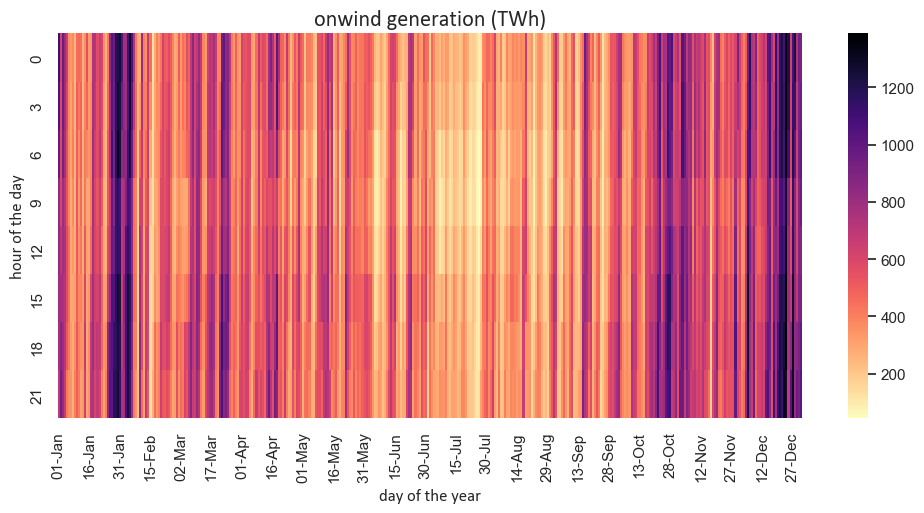

In [295]:
carrier = "onwind"

# get generation in TWh
df = pd.DataFrame(n.generators_t.p.loc[:, n.generators.carrier == carrier].sum(axis=1)) / 1000

hours = df.index.hour.unique()
df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

for hour in hours:
    df_start[str(hour)] = df[df.index.hour==hour].values

plt.figure(figsize=(12, 5))
ax = sns.heatmap(df_start.transpose(),
                 cmap=plt.get_cmap("magma_r"),
                 linewidth=0.001,
                 xticklabels=15)
plt.title(f"{carrier} generation (TWh)", fontsize=16, **font1)
plt.ylabel("hour of the day", fontsize=12, **font1)
plt.xlabel("day of the year", fontsize=12, **font1)

# Rewrite the y labels
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()

## Generation profiles

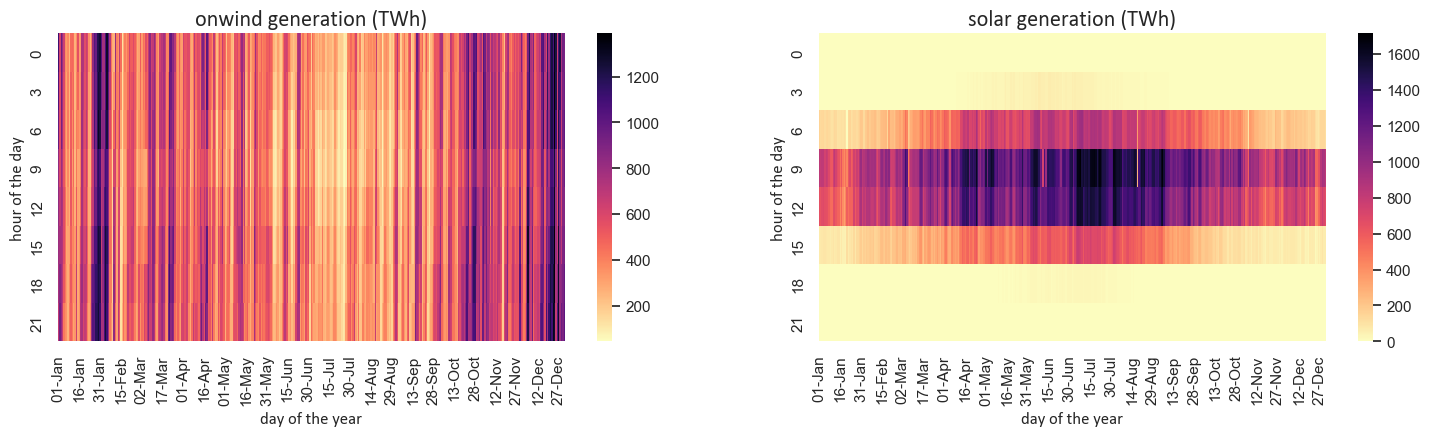

In [292]:
# generators
carriers = ["onwind", "solar"]

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(18, 4))

for i, ax in enumerate(axs):

    # get generation in TWh
    df = pd.DataFrame(n_no.generators_t.p.loc[:, n_no.generators.carrier == carriers[i]].sum(axis=1)) / 1000

    hours = df.index.hour.unique()
    df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

    for hour in hours:
        df_start[str(hour)] = df[df.index.hour==hour].values

    sns.heatmap(df_start.transpose(),
                ax=ax,
                cmap=plt.get_cmap("magma_r"),
                linewidth=0.001,
                xticklabels=15)

    ax.set_title(f"{carriers[i]} generation (TWh)", fontsize=16, **font1)
    ax.set_ylabel("hour of the day", fontsize=12, **font1)
    ax.set_xlabel("day of the year", fontsize=12, **font1)

    # Rewrite the y labels
    x_labels = ax.get_xticks()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()

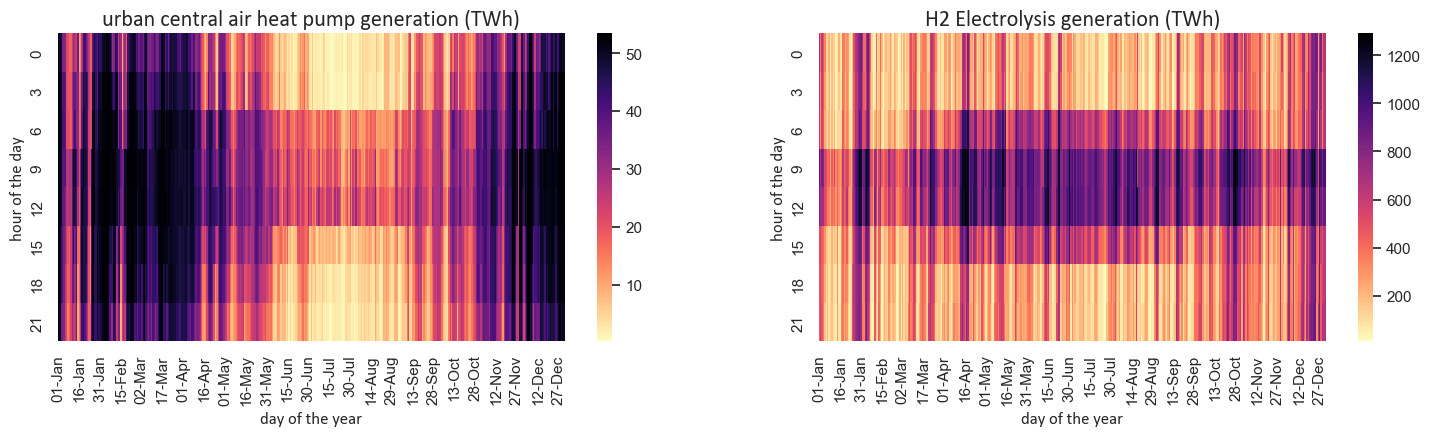

In [293]:
# links
carriers = ["urban central air heat pump", "H2 Electrolysis"]

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(18, 4))

for i, ax in enumerate(axs):

    # get generation in TWh
    df = pd.DataFrame(n_no.links_t.p0.loc[:, n_no.links.carrier == carriers[i]].sum(axis=1)) / 1000

    hours = df.index.hour.unique()
    df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

    for hour in hours:
        df_start[str(hour)] = df[df.index.hour==hour].values

    sns.heatmap(df_start.transpose(),
                ax=ax,
                cmap=plt.get_cmap("magma_r"),
                linewidth=0.001,
                xticklabels=15)

    ax.set_title(f"{carriers[i]} generation (TWh)", fontsize=16, **font1)
    ax.set_ylabel("hour of the day", fontsize=12, **font1)
    ax.set_xlabel("day of the year", fontsize=12, **font1)

    # Rewrite the y labels
    x_labels = ax.get_xticks()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()